## Packages

In [ ]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import statistics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import re

In [ ]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf

In [ ]:
from tensorflow import stack
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from keras.layers import Conv1D, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping

### UTD-MHAD Dataset extraction

In [ ]:
!git clone https://github.com/sanjeetarya001/UTD_MHAD_Dataset

Cloning into 'UTD_MHAD_Dataset'...
remote: Enumerating objects: 864, done.
remote: Counting objects: 100% (864/864), done.
remote: Compressing objects: 100% (863/863), done.
remote: Total 864 (delta 0), reused 864 (delta 0), pack-reused 0
Receiving objects: 100% (864/864), 4.98 MiB | 16.45 MiB/s, done.


## Dataset Preparation

In [ ]:
wrist_activities = []
for i in range(1, 22):
  wrist_activity_id = "a" + str(i)
  wrist_activities.append(wrist_activity_id)

In [ ]:
ordered_file_names = list()
for subject_number in range(1, 9):
  subject_name = "s" + str(subject_number)
  for trial_number in range(1, 5):
    trial_name = "t" + str(trial_number)
    for activity_number in range(1, 22):
      activity_name = "a" + str(activity_number)
      file_name = "_".join([activity_name, subject_name, trial_name])
      file_name = file_name + "_inertial" + ".mat"
      ordered_file_names.append(file_name)

In [ ]:
wrist_sensor_data = []
for file in ordered_file_names:
  try:
    data = loadmat(os.path.join("/content/UTD_MHAD_Dataset/Inertial", file))
  except FileNotFoundError:
    print(f"File not present: {file}")
    continue
  data_df = pd.DataFrame(data["d_iner"])
  data_df["Activity_ID"] = int(file.split("_")[0].strip("a"))
  data_df["Subject_ID"] = int(file.split("_")[1].strip("s"))
  data_df["Trail_ID"] = int(file.split("_")[2].strip("t"))
  wrist_sensor_data.append(data_df)

File not present: a8_s1_t4_inertial.mat


In [ ]:
wrist_sensor_data_df = pd.concat(wrist_sensor_data)

In [ ]:
wrist_sensor_data_df.head()

,0,1,2,3,4,5,Activity_ID,Subject_ID,Trail_ID
0,-0.959473,-0.177734,-0.192871,5.221374,1.526718,0.152672,1,1,1
1,-0.961914,-0.153320,-0.159912,6.778626,1.954198,0.244275,1,1,1
2,-0.974609,-0.152832,-0.145996,11.267176,3.175573,1.099237,1,1,1
3,-0.941895,-0.135742,-0.127930,16.885496,4.732824,2.320611,1,1,1
4,-0.958252,-0.201416,-0.139404,16.030534,4.000000,0.366412,1,1,1


In [ ]:
wrist_sensor_data_df.shape

(119897, 9)

In [ ]:
wrist_sensor_data_df.columns = ["ACC_X", "ACC_Y", "ACC_Z", "GYRO_X", "GYRO_Y", "GYRO_Z", "Activity_ID", "Subject_ID", "Trial_ID"]

In [ ]:
wrist_sensor_data_df.head()

,ACC_X,ACC_Y,ACC_Z,GYRO_X,GYRO_Y,GYRO_Z,Activity_ID,Subject_ID,Trial_ID
0,-0.959473,-0.177734,-0.192871,5.221374,1.526718,0.152672,1,1,1
1,-0.961914,-0.153320,-0.159912,6.778626,1.954198,0.244275,1,1,1
2,-0.974609,-0.152832,-0.145996,11.267176,3.175573,1.099237,1,1,1
3,-0.941895,-0.135742,-0.127930,16.885496,4.732824,2.320611,1,1,1
4,-0.958252,-0.201416,-0.139404,16.030534,4.000000,0.366412,1,1,1


## EDA on the dataset

In [ ]:
wrist_sensor_data_df.dtypes

ACC_X          float64
ACC_Y          float64
ACC_Z          float64
GYRO_X         float64
GYRO_Y         float64
GYRO_Z         float64
Activity_ID      int64
Subject_ID       int64
Trial_ID         int64
dtype: object

In [ ]:
wrist_sensor_data_df['Activity_ID'].value_counts()

21    7473
12    6801
14    6453
11    6432
9     6327
10    6208
17    5897
19    5801
13    5719
15    5632
3     5587
6     5496
8     5387
4     5215
18    5206
1     5150
7     5147
20    4999
16    4993
5     4990
2     4984
Name: Activity_ID, dtype: int64

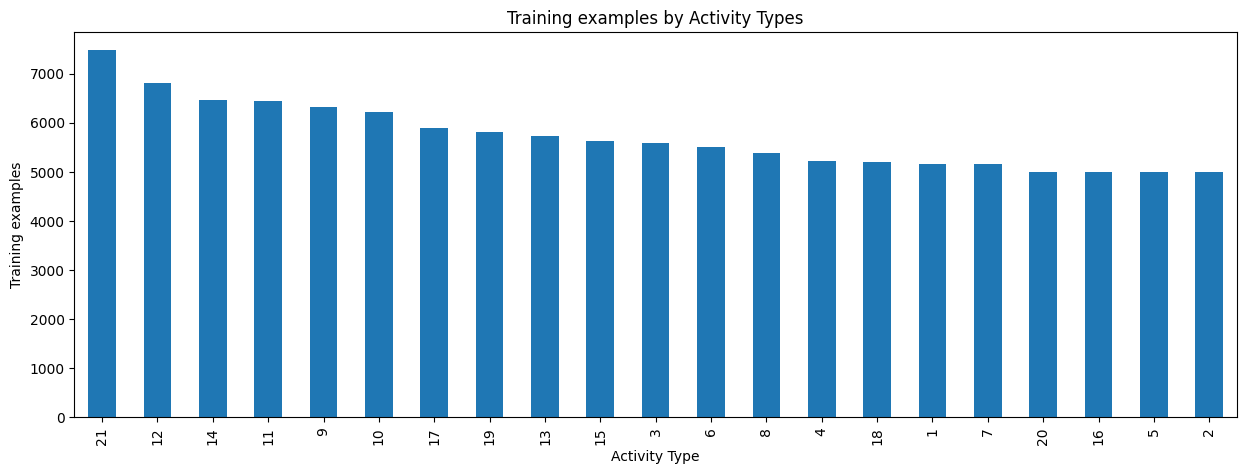

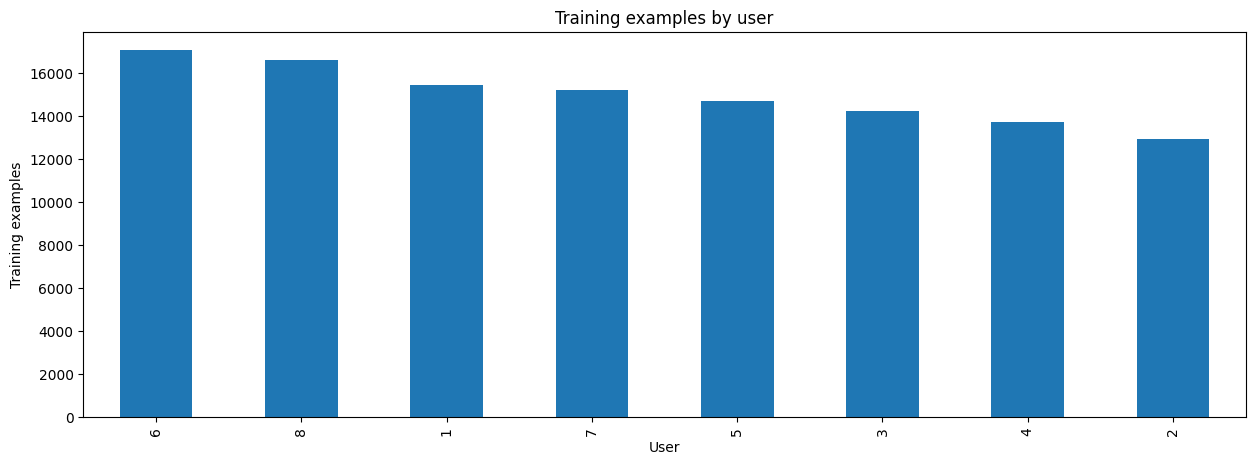

In [ ]:
plt.figure(figsize=(15, 5))

plt.xlabel('Activity Type')
plt.ylabel('Training examples')
wrist_sensor_data_df['Activity_ID'].value_counts().plot(kind='bar',
                                  title='Training examples by Activity Types')
plt.show()

plt.figure(figsize=(15, 5))
plt.xlabel('User')
plt.ylabel('Training examples')
wrist_sensor_data_df['Subject_ID'].value_counts().plot(kind='bar',
                                 title='Training examples by user')
plt.show()

In [ ]:
def axis_plot(ax, x, y, title):
    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

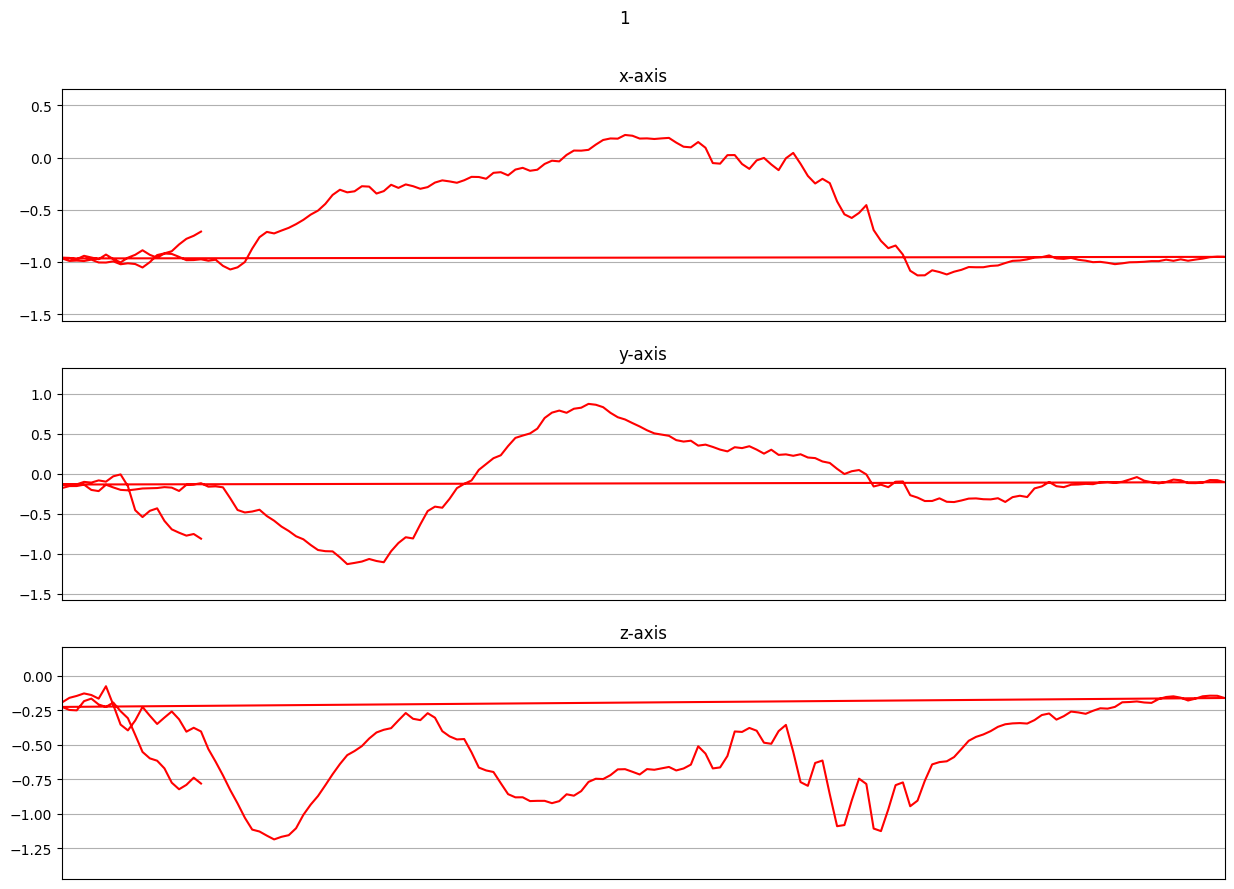

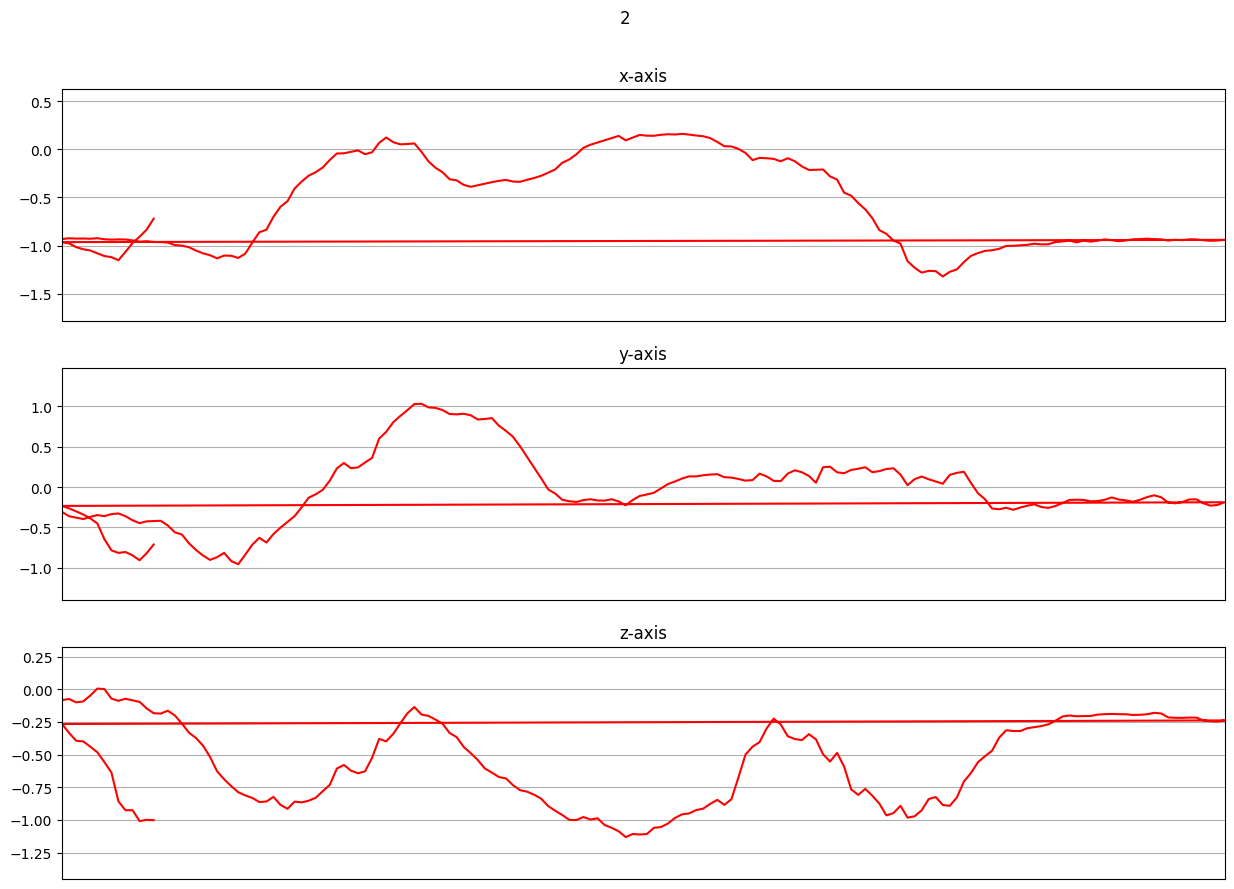

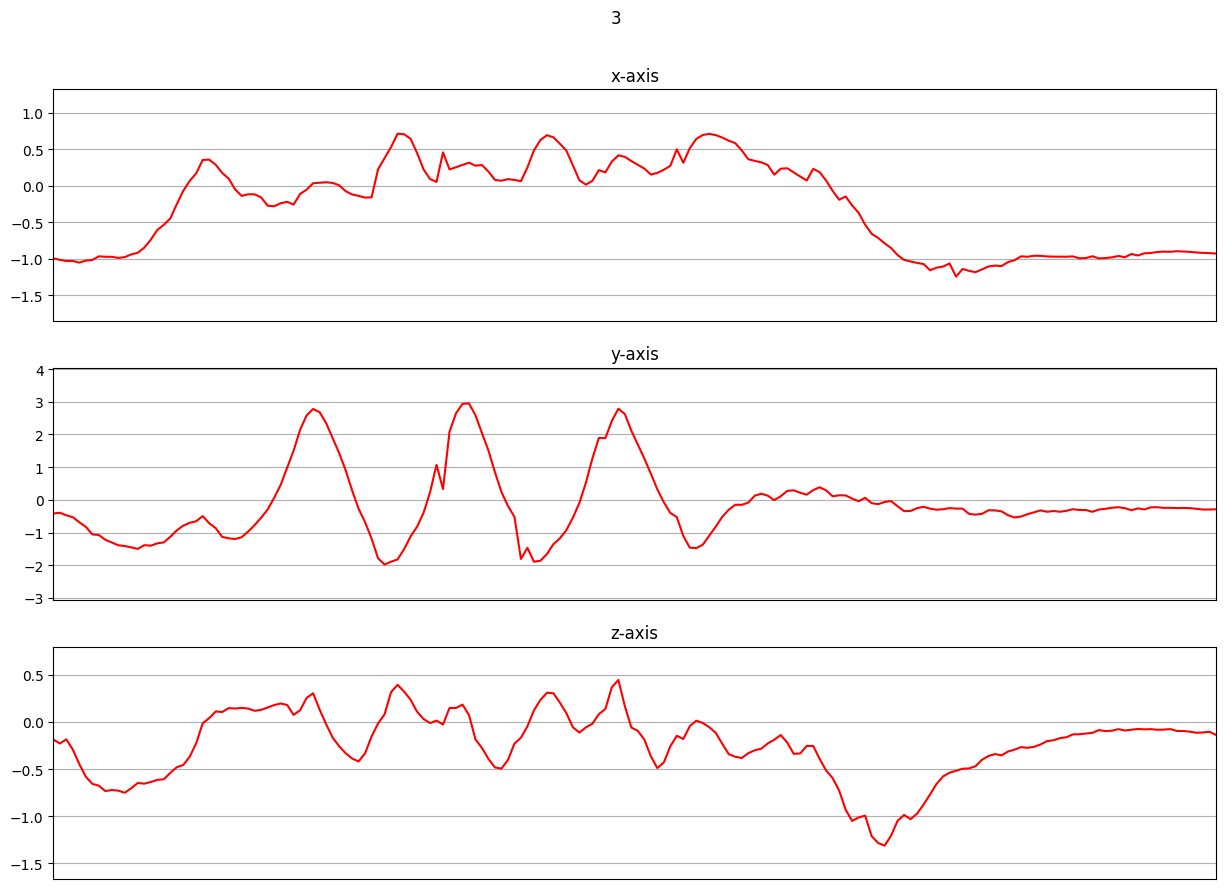

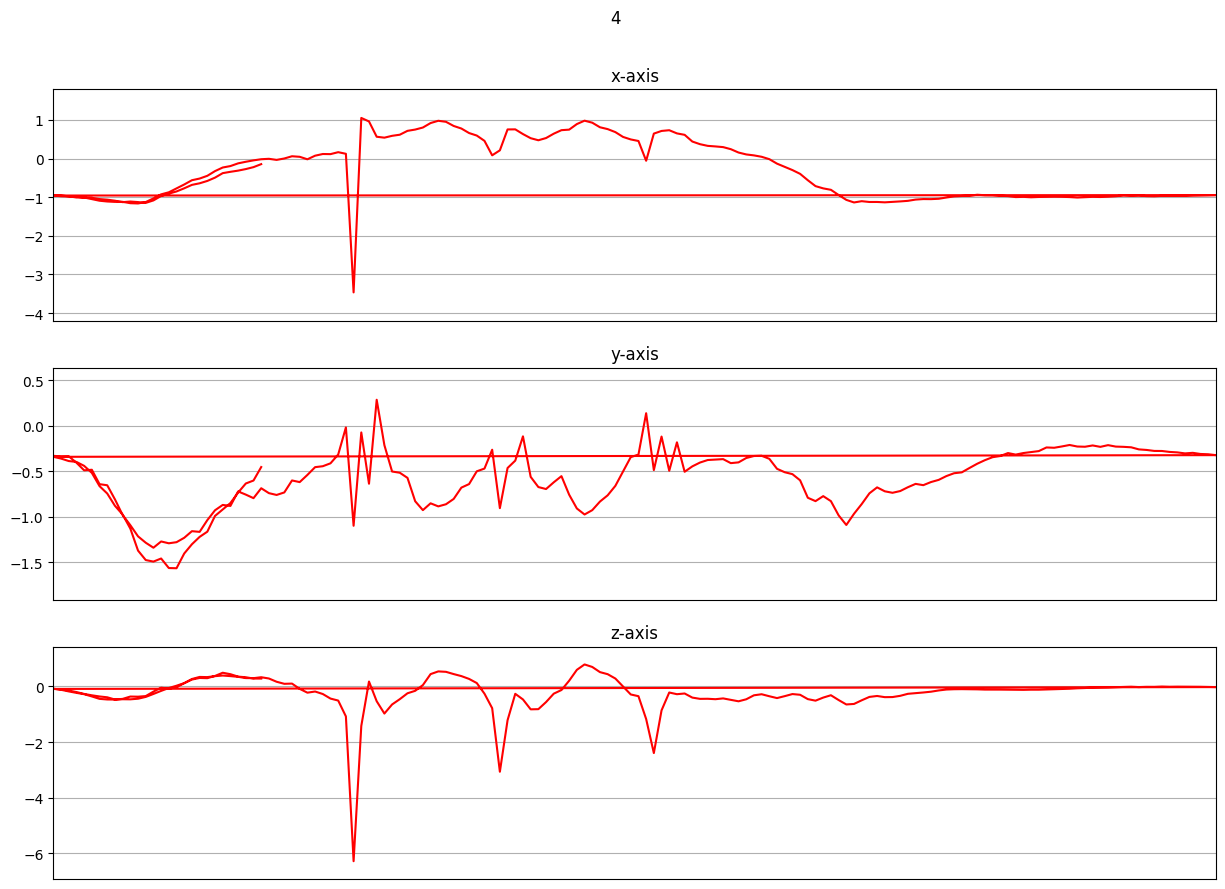

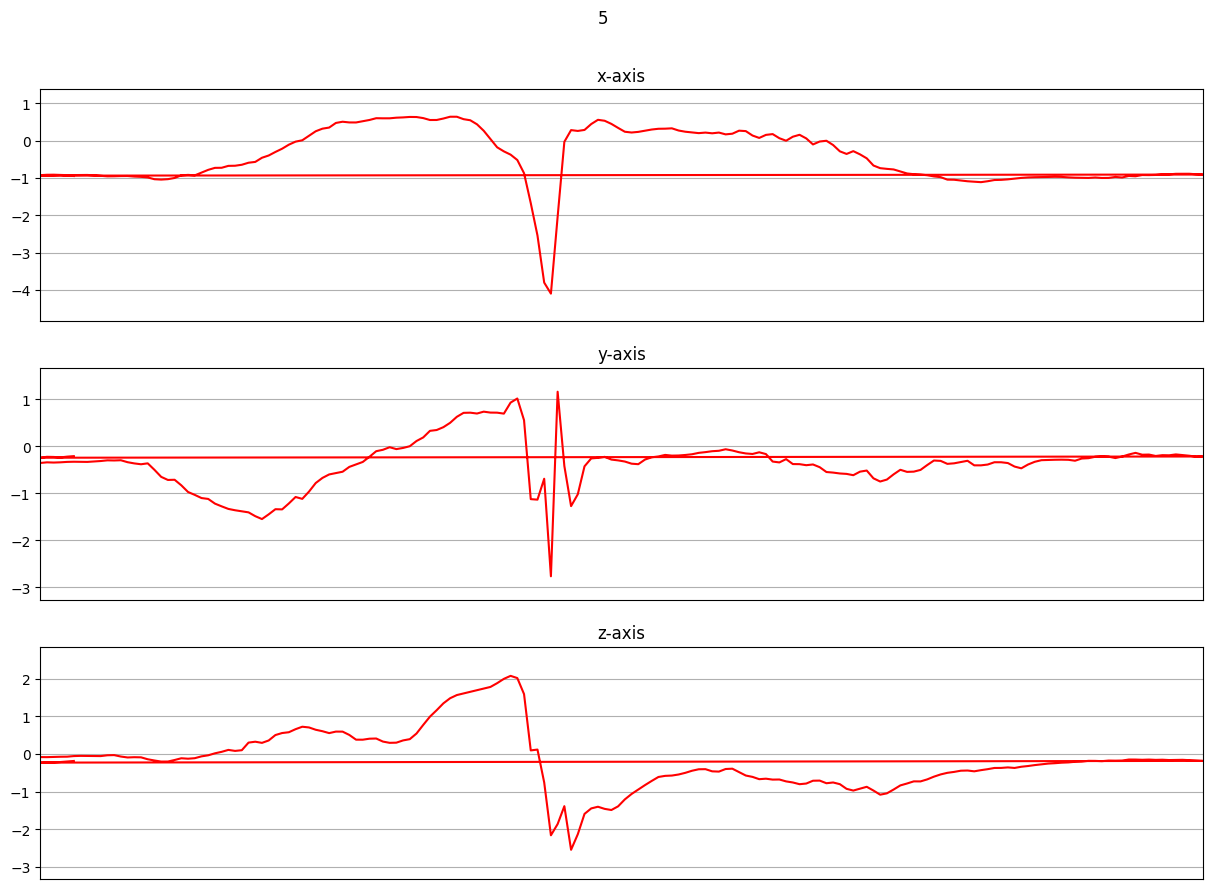

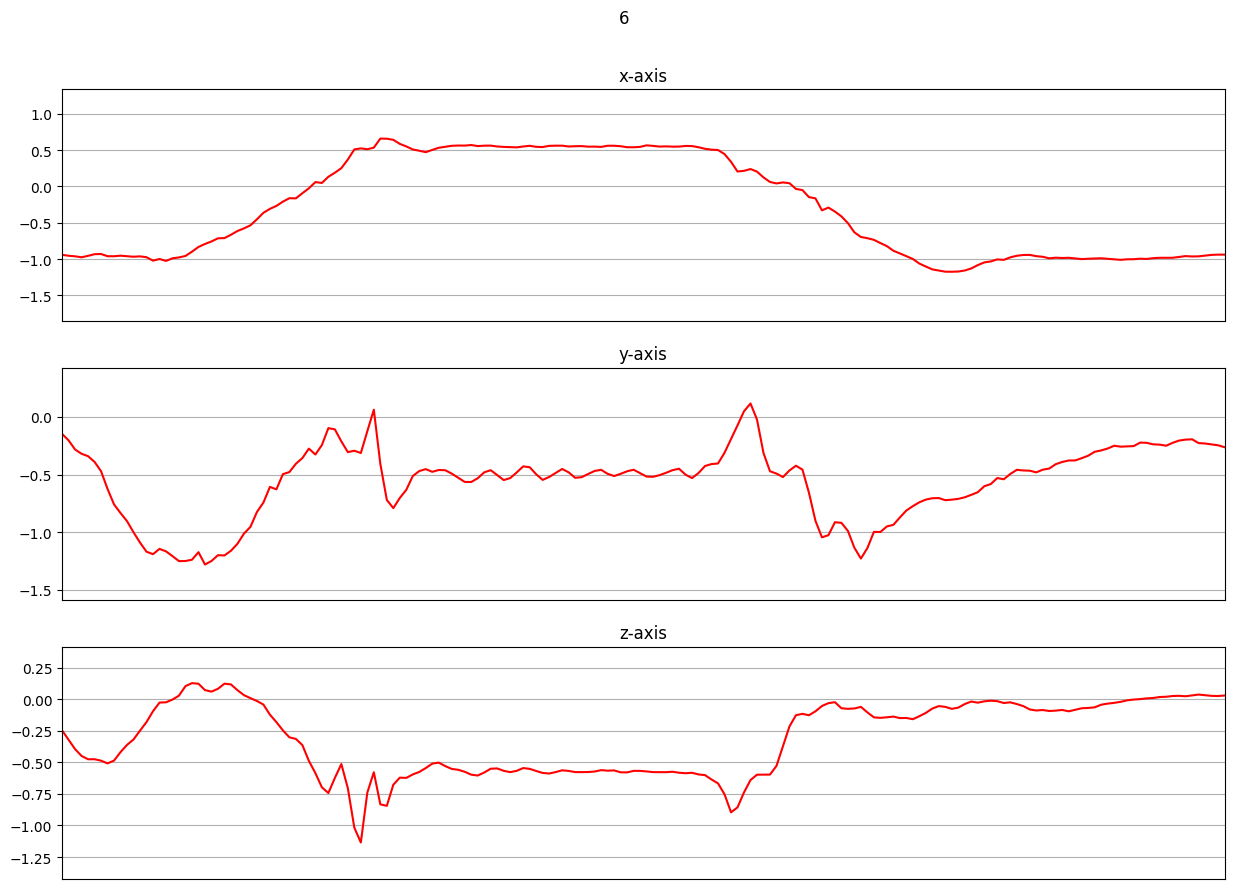

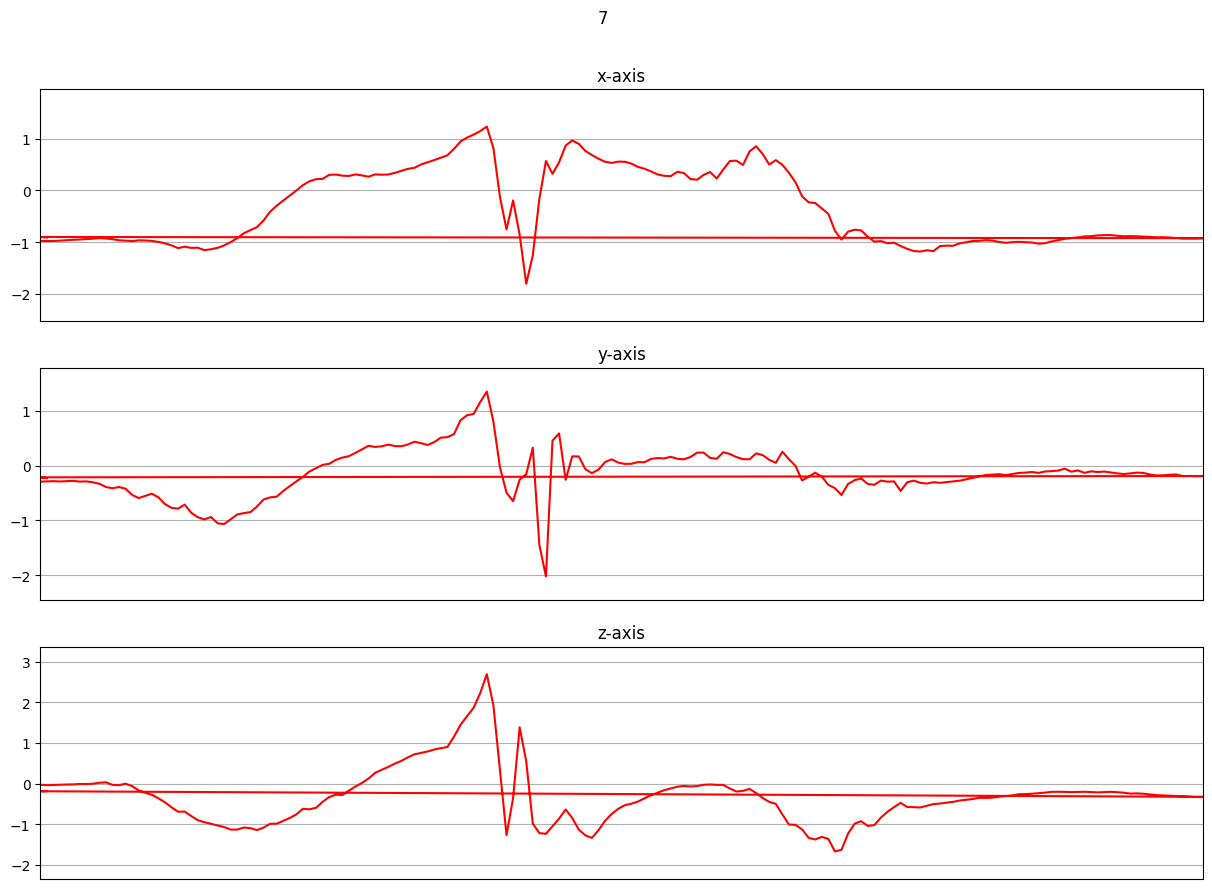

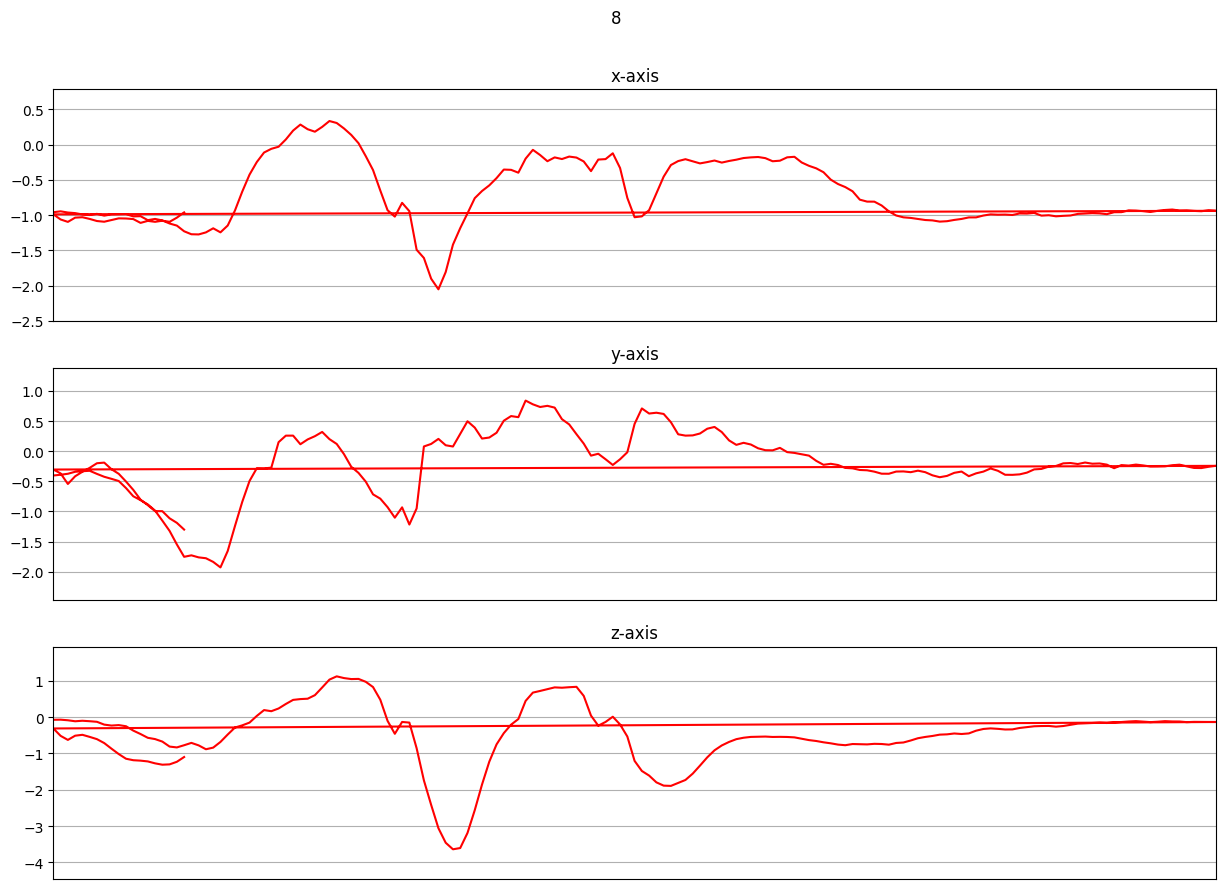

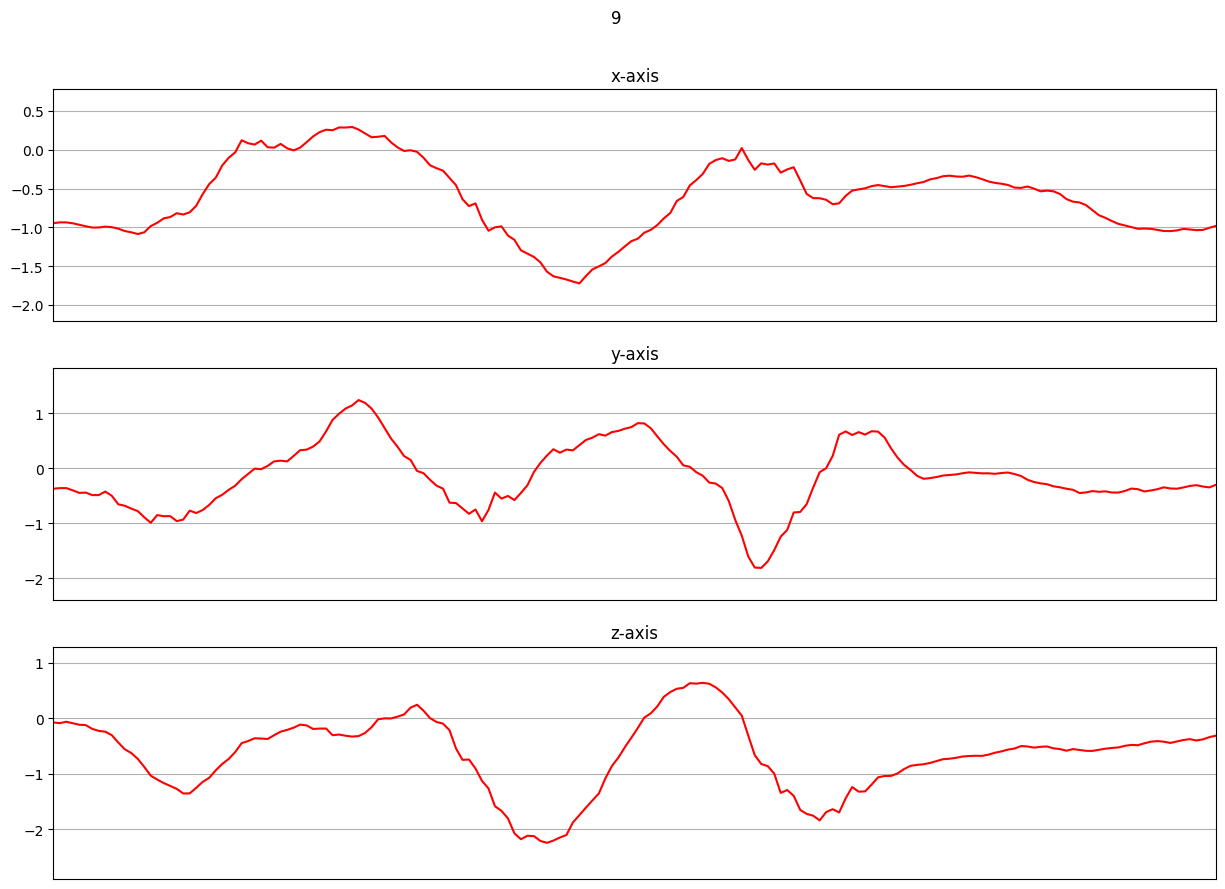

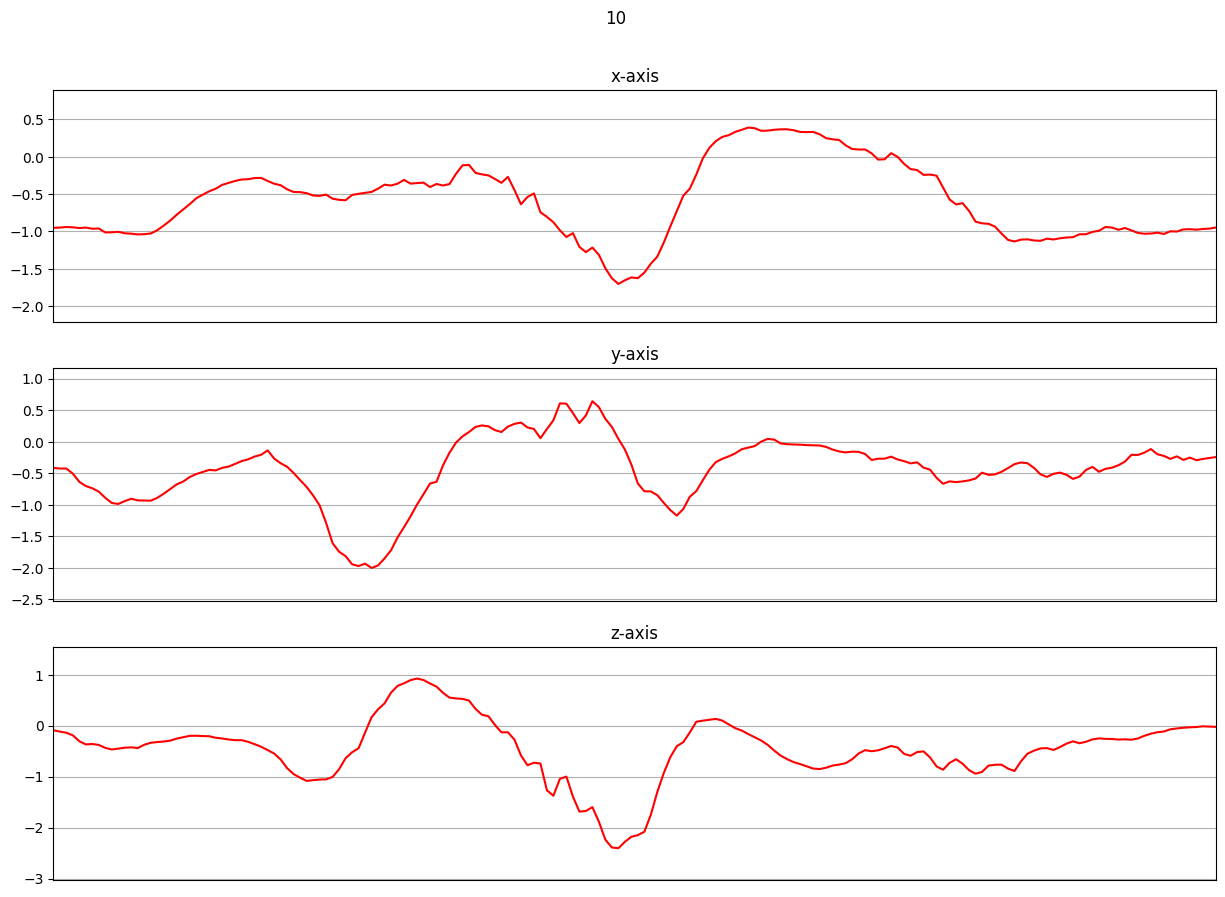

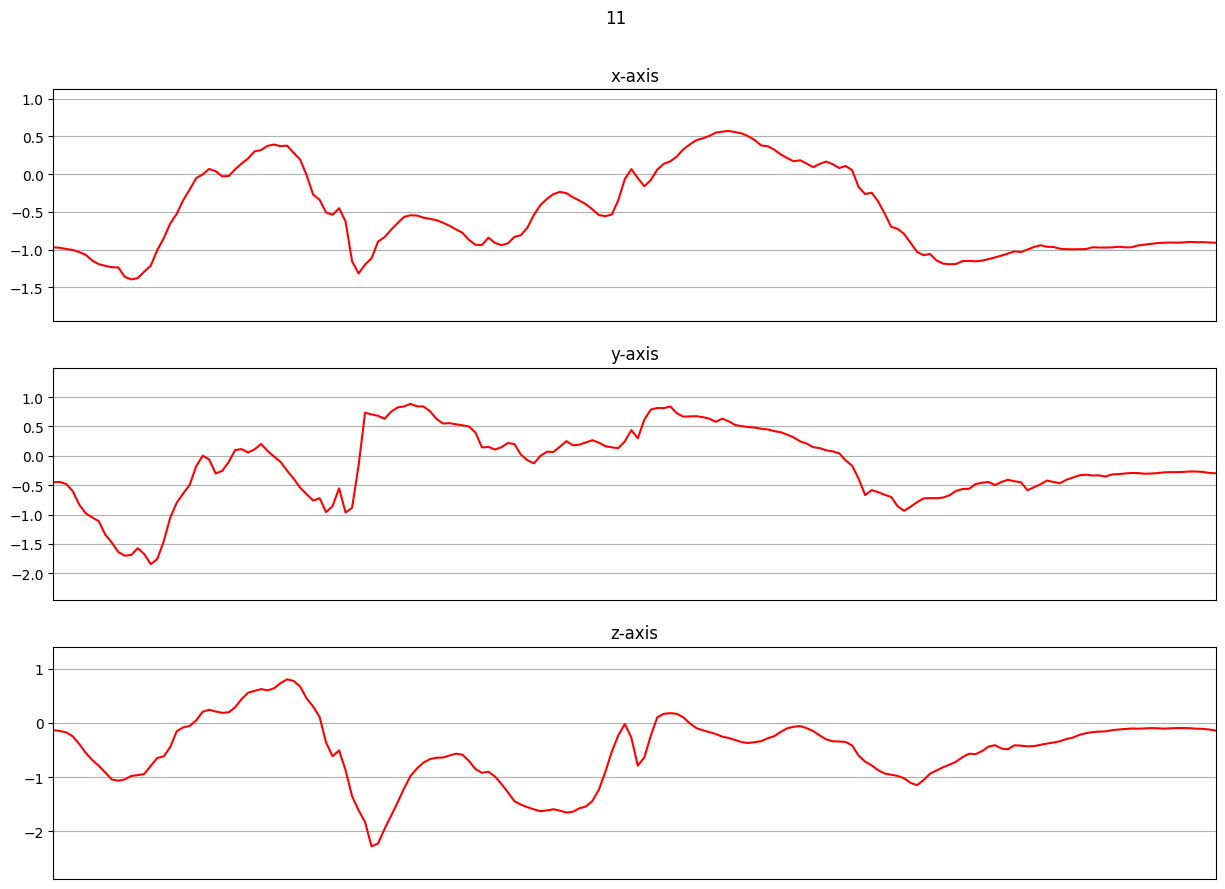

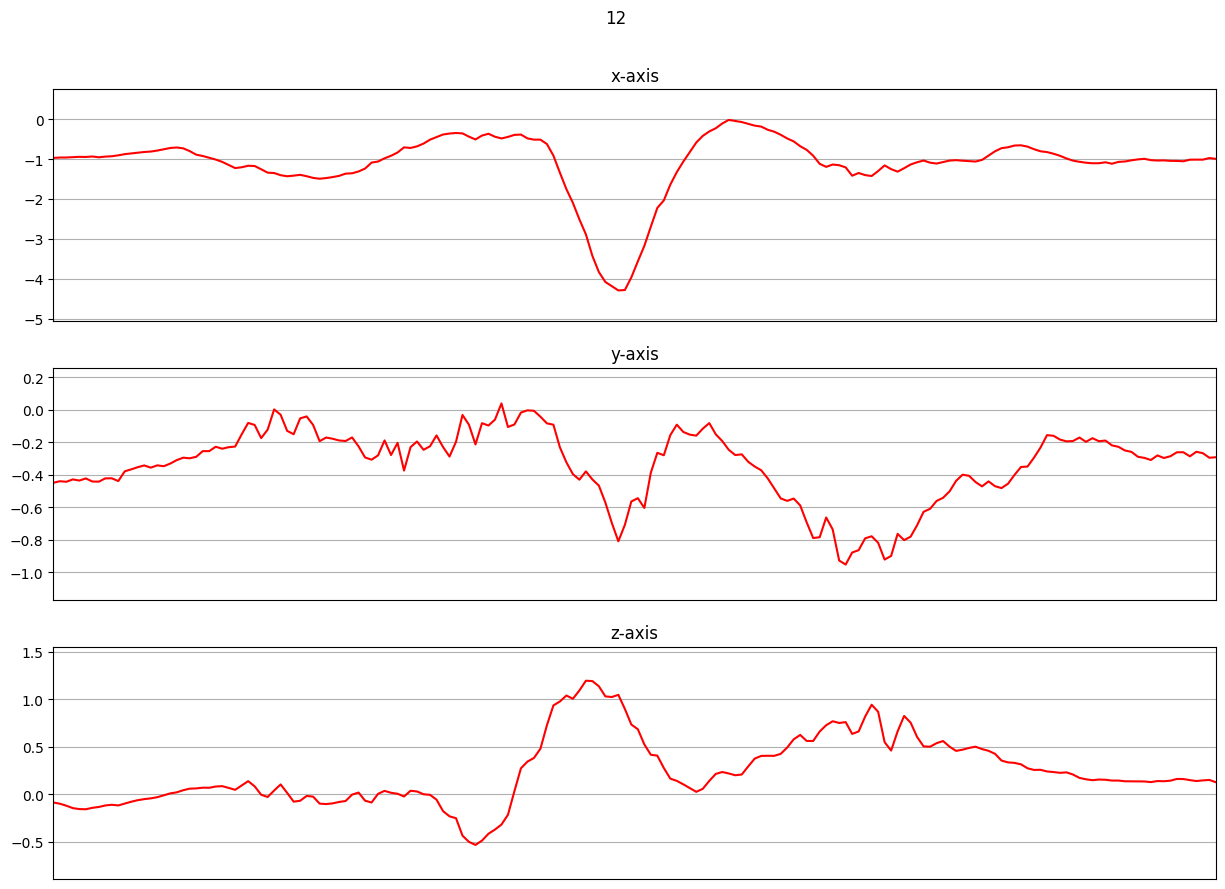

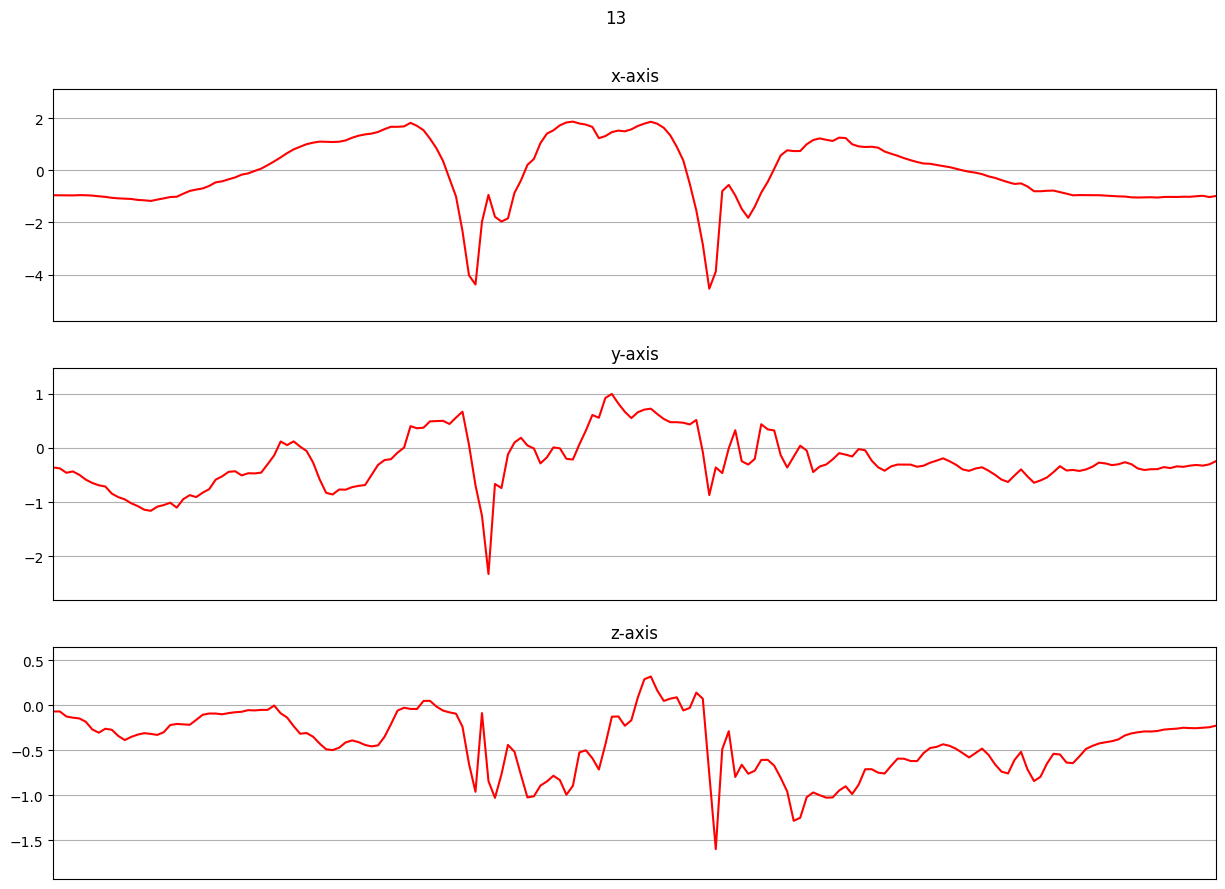

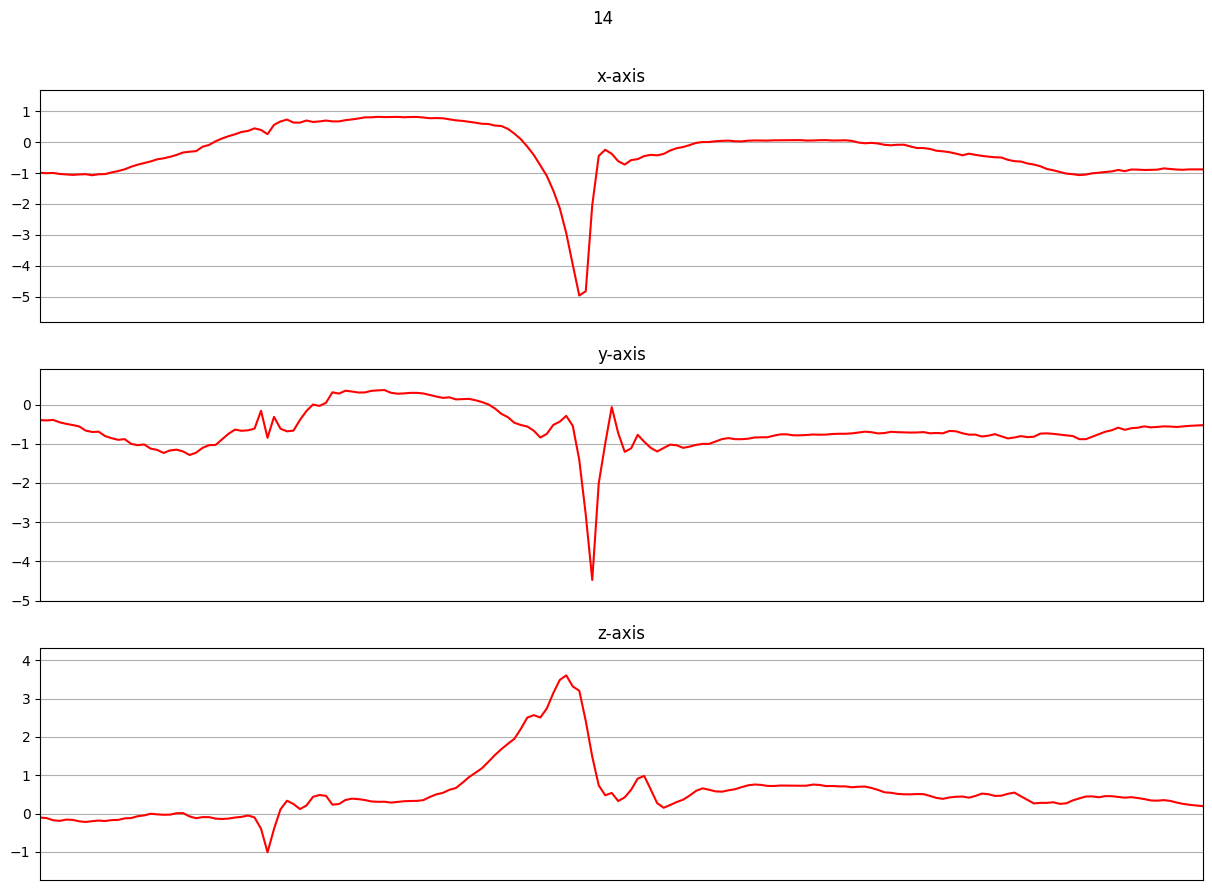

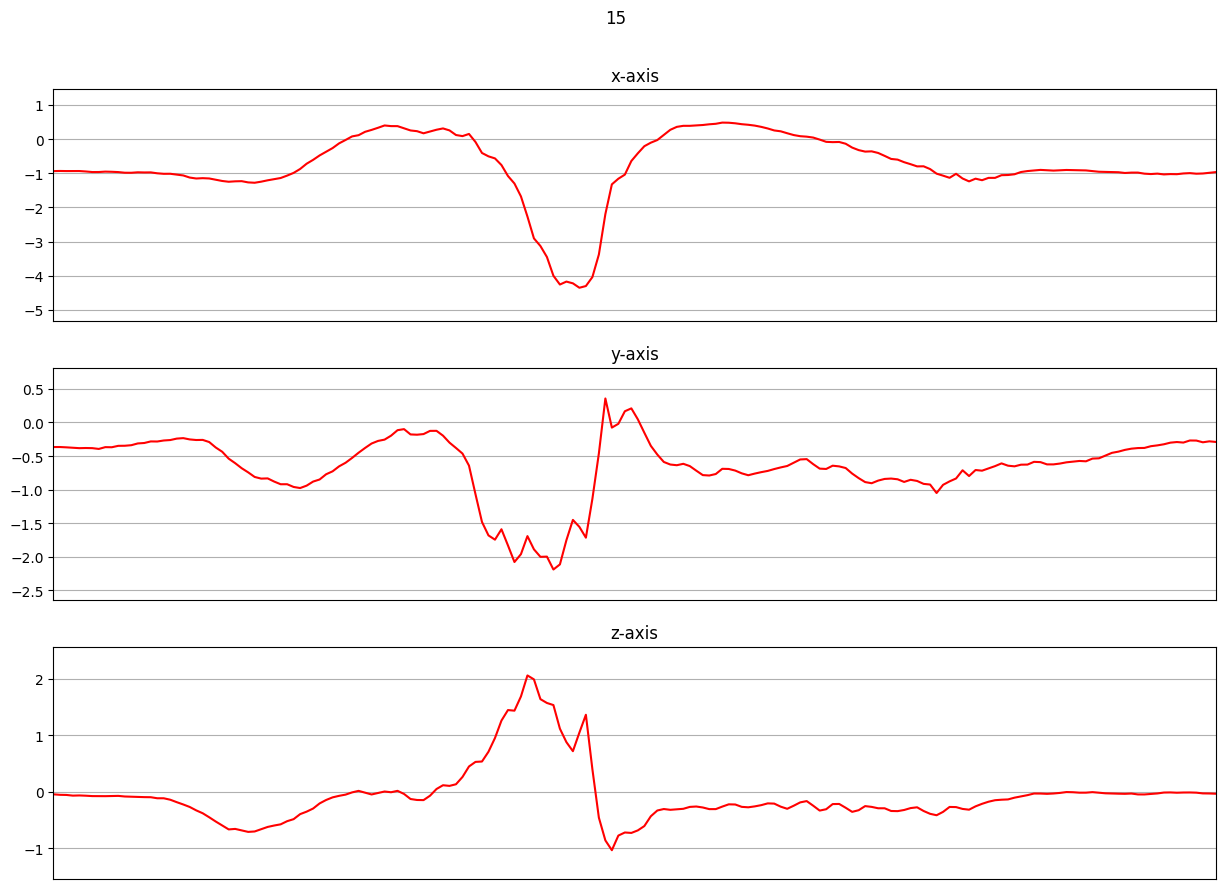

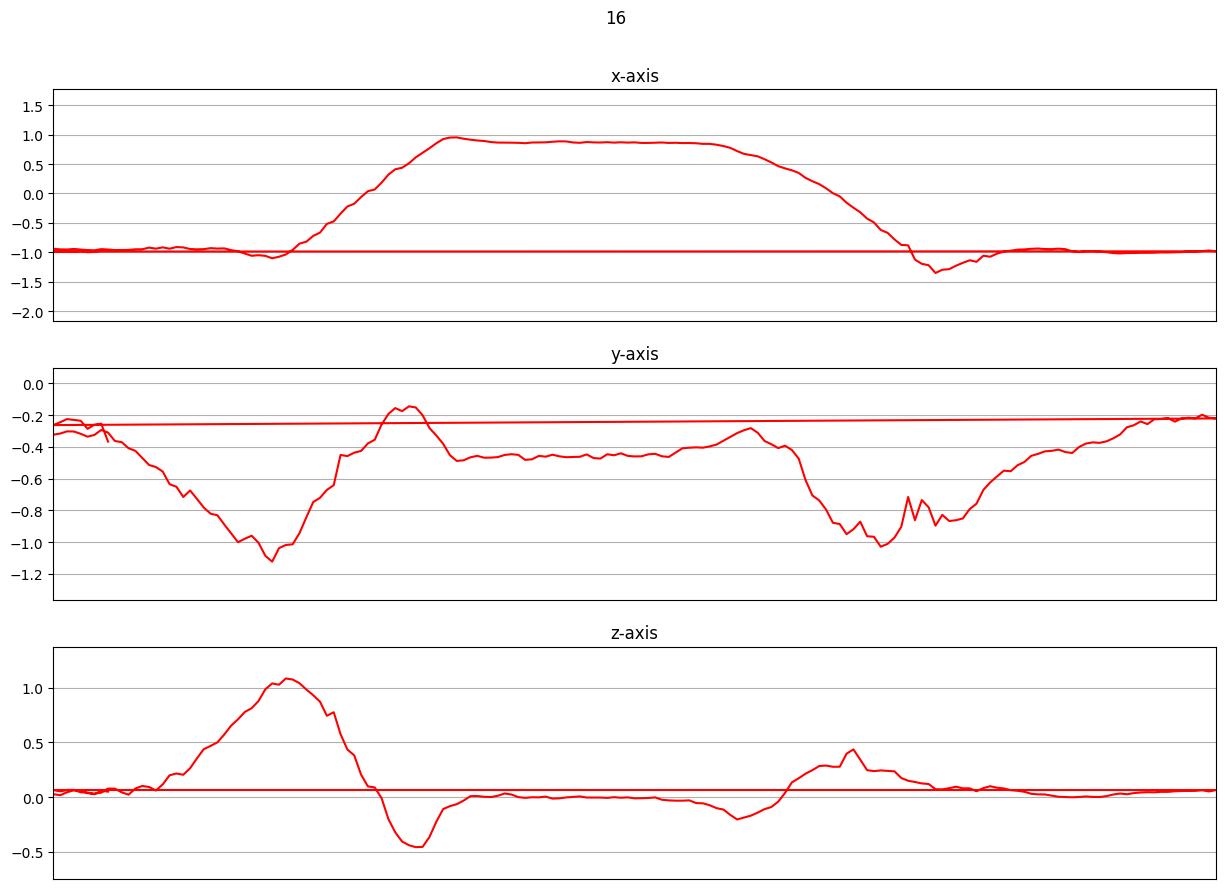

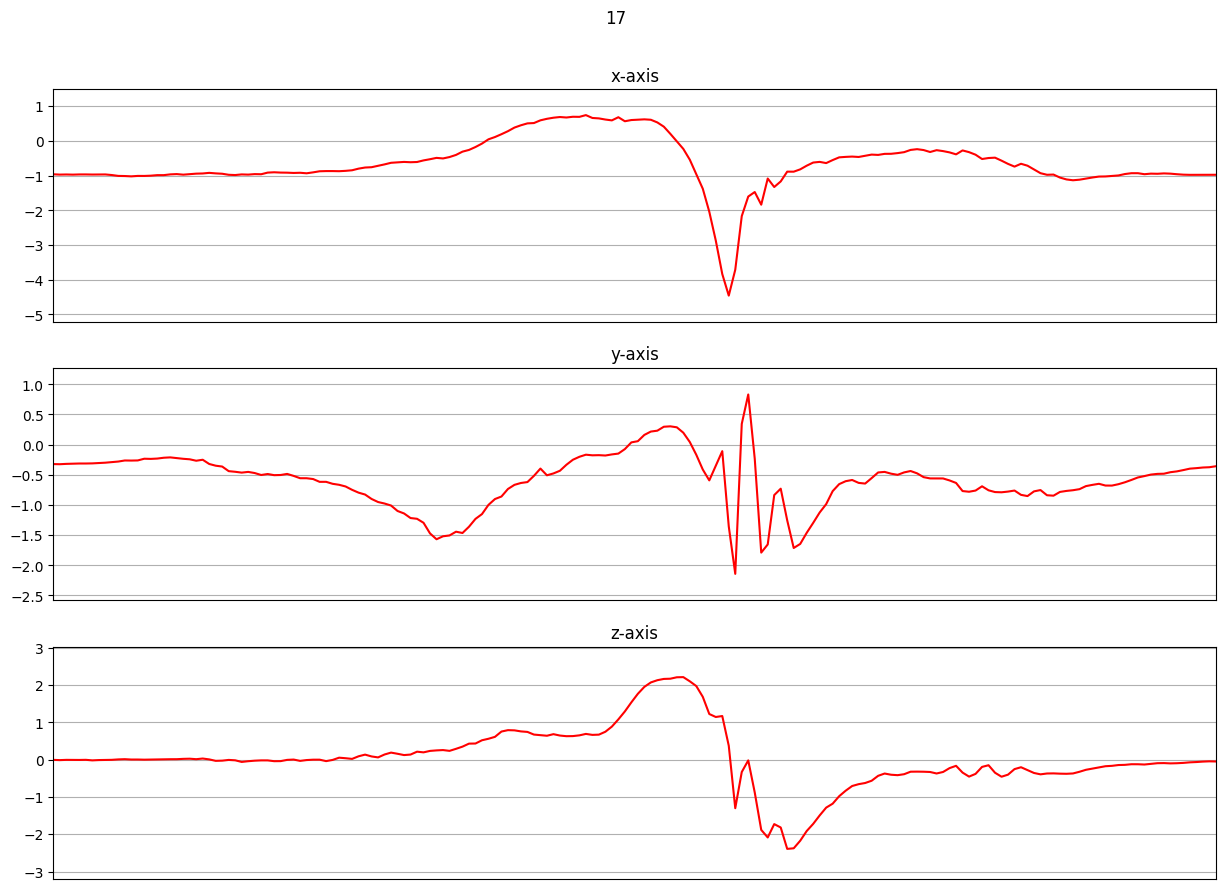

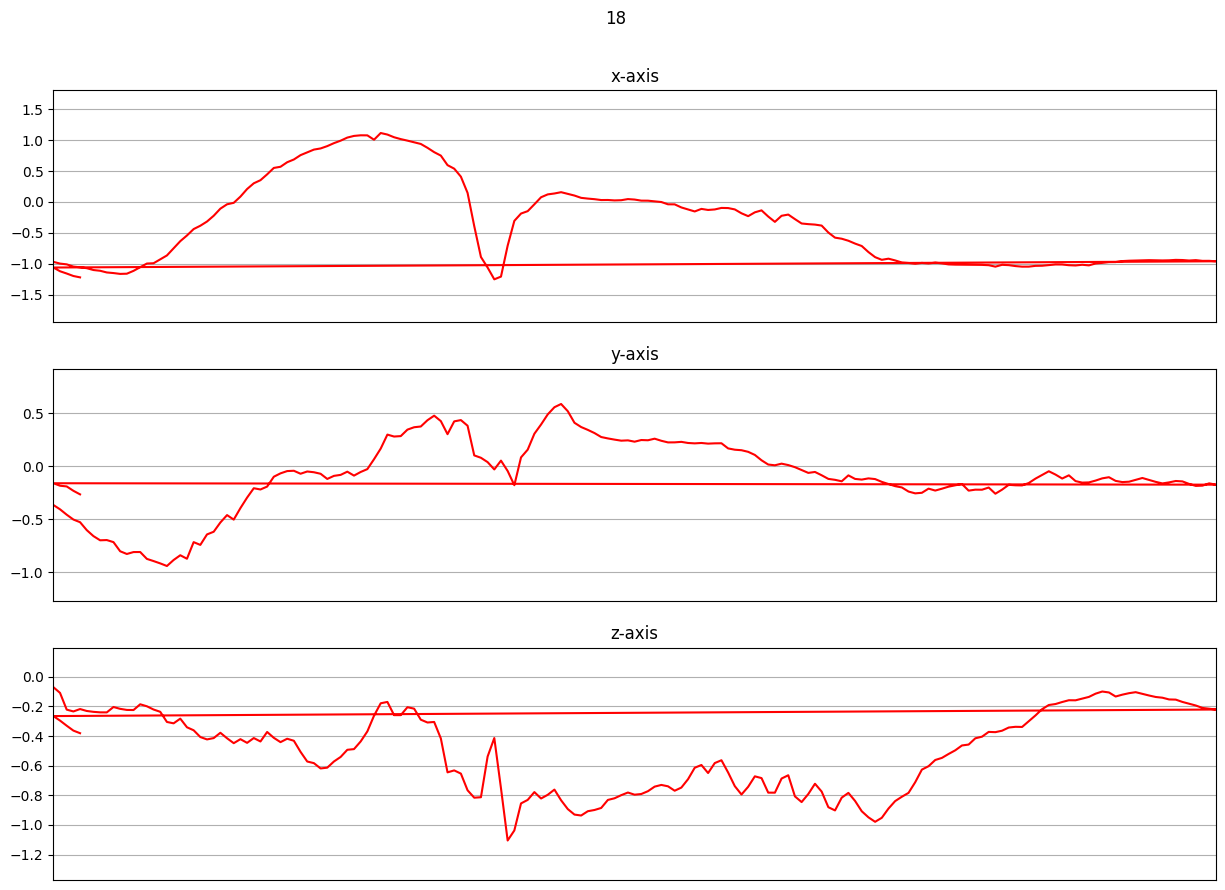

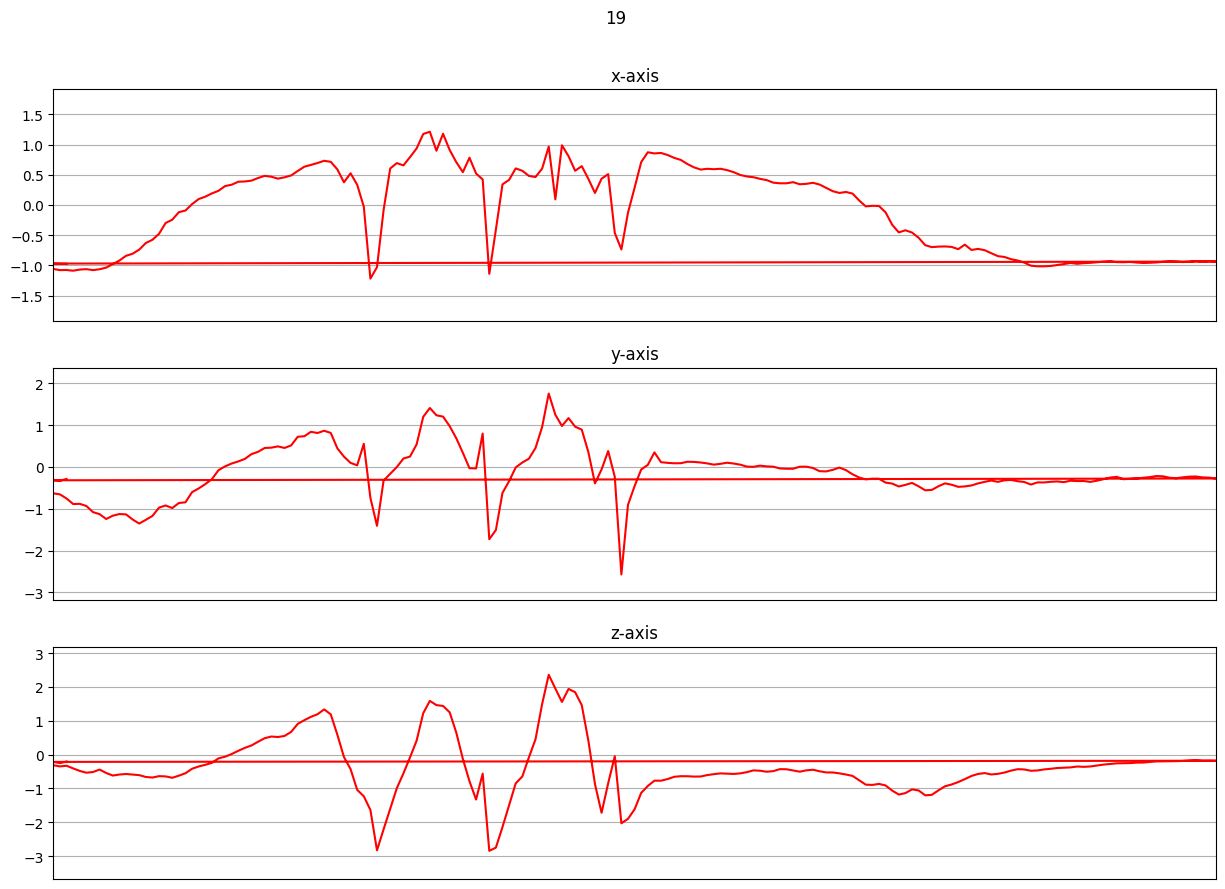

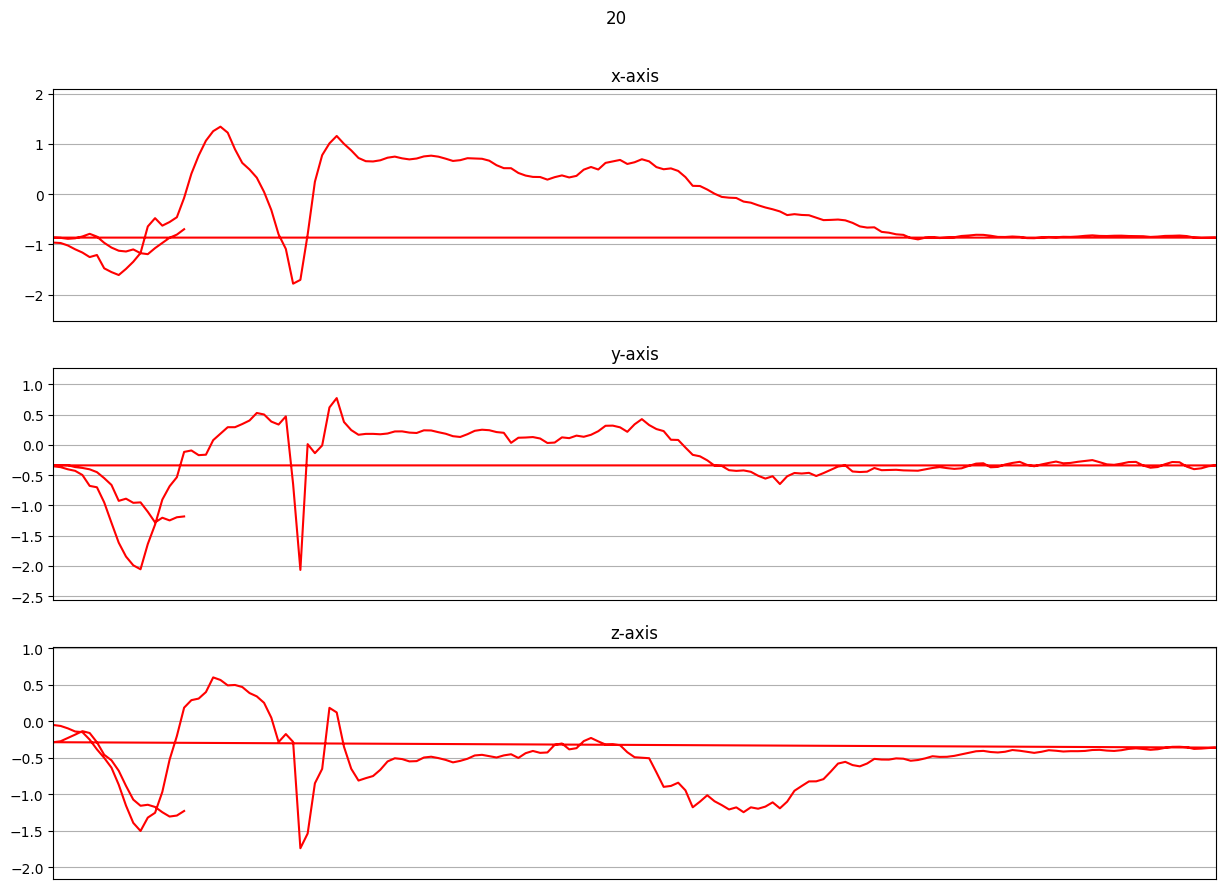

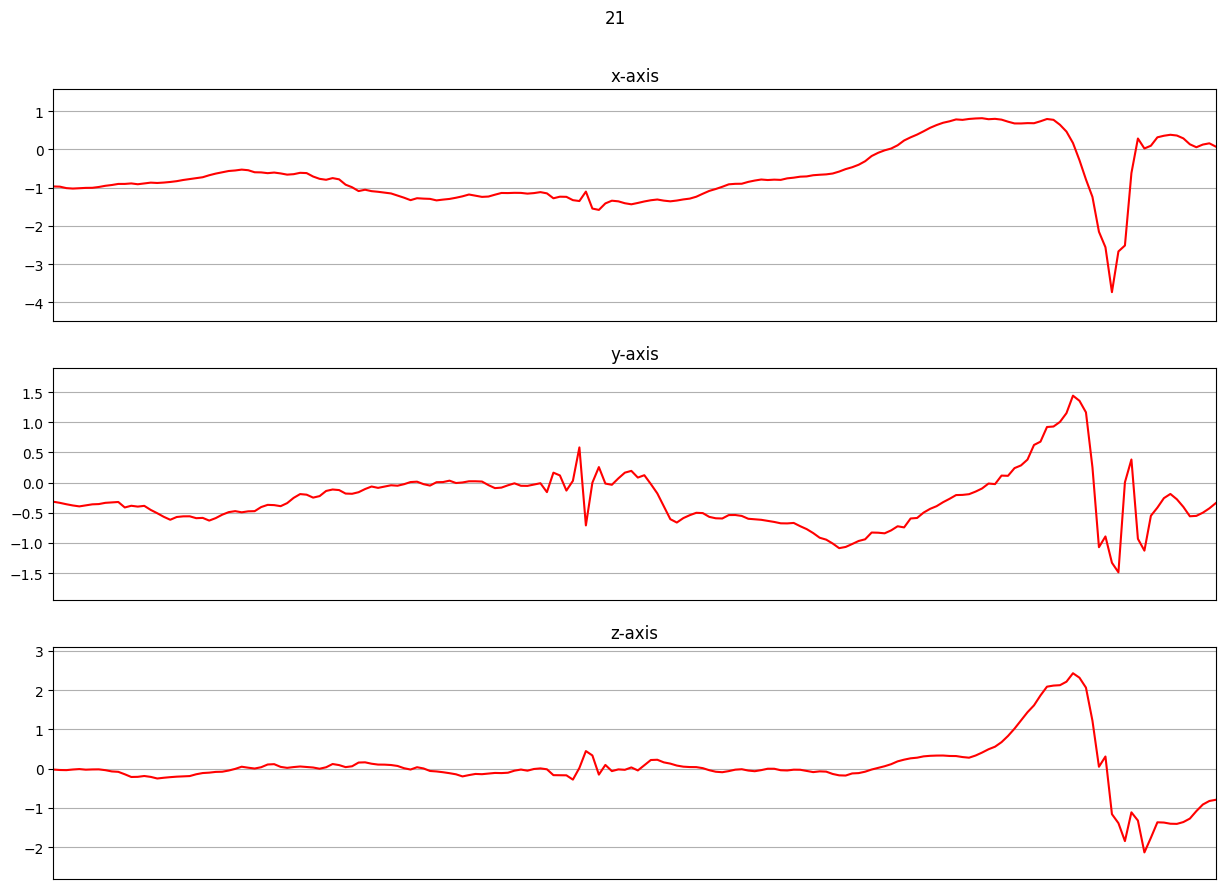

In [ ]:
for activity in wrist_sensor_data_df['Activity_ID'].unique():
    limit = wrist_sensor_data_df[wrist_sensor_data_df['Activity_ID'] == activity][:180]
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True, figsize=(15, 10))
    axis_plot(ax0, limit.index, limit['ACC_X'], 'x-axis')
    axis_plot(ax1, limit.index, limit['ACC_Y'], 'y-axis')
    axis_plot(ax2, limit.index, limit['ACC_Z'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.9)
    plt.show()

In [ ]:
wrist_sensor_data_df['Subject_ID'].unique()

array([1, 2, 3, 4, 5, 6, 7, 8])

## Signal Isolation

In [ ]:
from scipy.signal import butter, lfilter

In [ ]:
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

In [ ]:
def apply_lowpass_filter(data, cutoff_freq, sampling_freq, filter_order=5):
    b, a = butter_lowpass(cutoff_freq, sampling_freq, order=filter_order)
    y = lfilter(b, a, data)
    return y

In [ ]:
cutoff_frequency = 0.3
sampling_frequency = 50

In [ ]:
activity_data = wrist_sensor_data_df[wrist_sensor_data_df["Activity_ID"] == 1]
activity_trial_subject_data = activity_data[(activity_data["Trial_ID"] == 1) & (activity_data["Subject_ID"] == 1)]
signal_values_x = activity_trial_subject_data["ACC_X"].values
gravity_component = apply_lowpass_filter(signal_values_x, cutoff_frequency, sampling_frequency)
body_component = signal_values_x - gravity_component

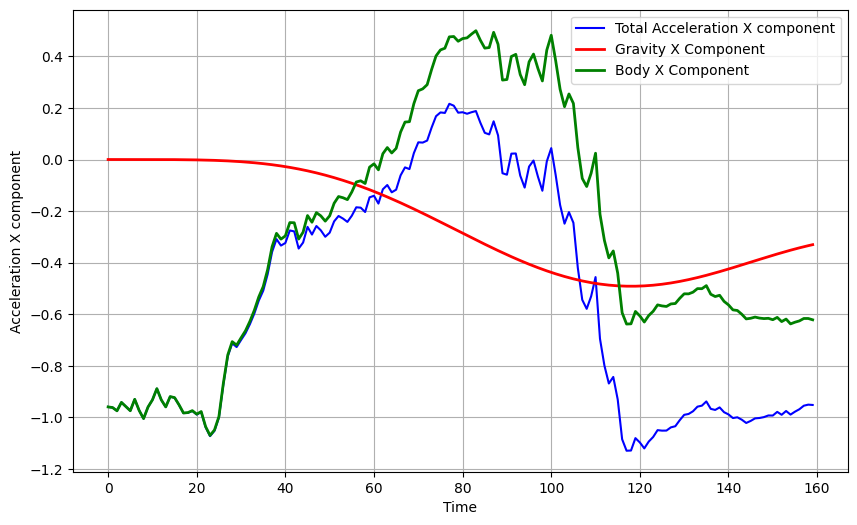

In [ ]:
# Plotting the original, gravity, and body components
plt.figure(figsize=(10, 6))
plt.plot(range(len(signal_values_x)), signal_values_x, 'b-', label='Total Acceleration X component')
plt.plot(range(len(signal_values_x)), gravity_component, 'r-', linewidth=2, label='Gravity X Component')
plt.plot(range(len(signal_values_x)), body_component, 'g-', linewidth=2, label='Body X Component')
plt.xlabel('Time')
plt.ylabel('Acceleration X component')
plt.legend()
plt.grid()
plt.show()

In [ ]:
activity_data = wrist_sensor_data_df[wrist_sensor_data_df["Activity_ID"] == 1]
activity_trial_subject_data = activity_data[(activity_data["Trial_ID"] == 1) & (activity_data["Subject_ID"] == 1)]
signal_values_y = activity_trial_subject_data["ACC_Y"].values
gravity_component = apply_lowpass_filter(signal_values_y, cutoff_frequency, sampling_frequency)
body_component = signal_values_y - gravity_component

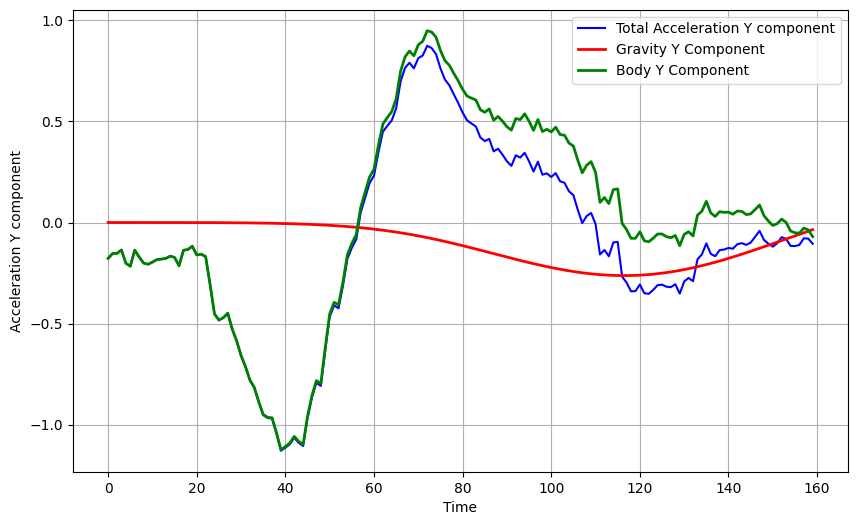

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(signal_values_y)), signal_values_y, 'b-', label='Total Acceleration Y component')
plt.plot(range(len(signal_values_y)), gravity_component, 'r-', linewidth=2, label='Gravity Y Component')
plt.plot(range(len(signal_values_y)), body_component, 'g-', linewidth=2, label='Body Y Component')
plt.xlabel('Time')
plt.ylabel('Acceleration Y component')
plt.legend()
plt.grid()
plt.show()

In [ ]:
activity_data = wrist_sensor_data_df[wrist_sensor_data_df["Activity_ID"] == 1]
activity_trial_subject_data = activity_data[(activity_data["Trial_ID"] == 1) & (activity_data["Subject_ID"] == 1)]
signal_values_z = activity_trial_subject_data["ACC_Z"].values
gravity_component = apply_lowpass_filter(signal_values_z, cutoff_frequency, sampling_frequency)
body_component = signal_values_z - gravity_component

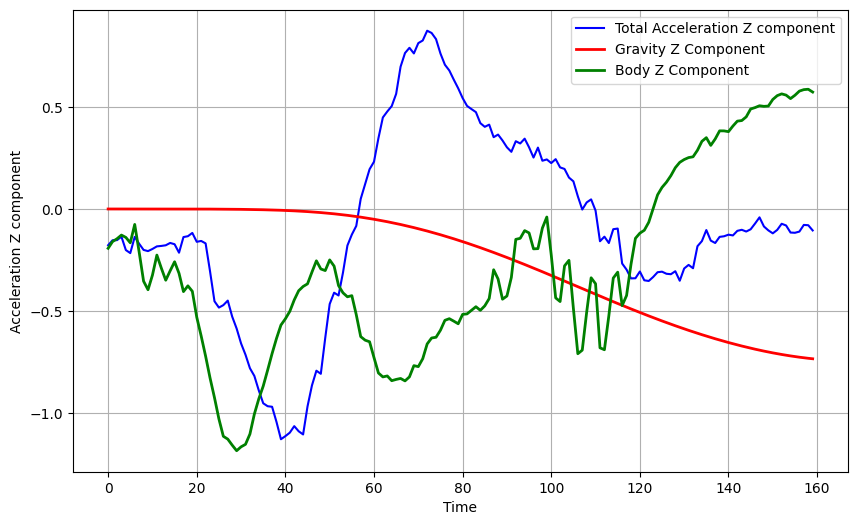

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(signal_values_y)), signal_values_y, 'b-', label='Total Acceleration Z component')
plt.plot(range(len(signal_values_y)), gravity_component, 'r-', linewidth=2, label='Gravity Z Component')
plt.plot(range(len(signal_values_y)), body_component, 'g-', linewidth=2, label='Body Z Component')
plt.xlabel('Time')
plt.ylabel('Acceleration Z component')
plt.legend()
plt.grid()
plt.show()

## Organizing data as Subject, Trial, Activity

In [ ]:
# Path to the Inertial folder
inertial_folder_path = '/content/UTD_MHAD_Dataset/Inertial'   # Replace with the actual path

# List all files in the Inertial folder
inertial_files = [f for f in os.listdir(inertial_folder_path) if f.endswith('.mat')]

# Filter files with numeric part less than or equal to 21 (Wrist Activities range from 1 upto 21)
wrist_inertial_files = [f for f in inertial_files if int(re.search(r'\d+', f.split('_')[0]).group()) <= 21]

In [ ]:
ordered_file_names = list()
for subject_number in range(1, 9):
  subject_name = "s" + str(subject_number)
  for trial_number in range(1, 5):
    trial_name = "t" + str(trial_number)
    for activity_number in range(1, 22):
      activity_name = "a" + str(activity_number)
      file_name = "_".join([activity_name, subject_name, trial_name])
      file_name = file_name + "_inertial" + ".mat"
      ordered_file_names.append(file_name)

In [ ]:
wrist_sensor_data = []
for file in ordered_file_names:
  try:
    data = loadmat(os.path.join(inertial_folder_path, file))
  except FileNotFoundError:
    print(f"File not present: {file}")
    continue
  data_df = pd.DataFrame(data["d_iner"])
  data_df["Activity_ID"] = int(file.split("_")[0].strip("a"))
  data_df["Subject_ID"] = int(file.split("_")[1].strip("s"))
  data_df["Trail_ID"] = int(file.split("_")[2].strip("t"))
  wrist_sensor_data.append(data_df)

File not present: a8_s1_t4_inertial.mat


In [ ]:
wrist_sensor_data_df = pd.concat(wrist_sensor_data)
wrist_sensor_data_df.columns = ["ACC_X", "ACC_Y", "ACC_Z", "GYRO_X", "GYRO_Y", "GYRO_Z", "Activity_ID", "Subject_ID", "Trial_ID"]

In [ ]:
UTD1_dataset = wrist_sensor_data_df.copy()
# Display the final dataset
print("Shape of the UTD1 Dataset:", UTD1_dataset.shape)
print("Columns of the UTD1 Dataset:", UTD1_dataset.columns)
UTD1_dataset.reset_index(drop=True, inplace=True)

Shape of the UTD1 Dataset: (119897, 9)
Columns of the UTD1 Dataset: Index(['ACC_X', 'ACC_Y', 'ACC_Z', 'GYRO_X', 'GYRO_Y', 'GYRO_Z', 'Activity_ID',
       'Subject_ID', 'Trial_ID'],
      dtype='object')


## Groupby [ subject, trial ]. 8 Subject * 4 trial == 32 Groups

In [ ]:
grouped_data = UTD1_dataset.groupby(['Subject_ID', 'Trial_ID'])

# Initialize an empty list to store group DataFrames
group_list = []

# Iterate through the groups and append each group to the list
for _, group_data in grouped_data:
    group_df = group_data.reset_index(drop=True)  # Reset index and drop old index column
    group_list.append(group_df)

In [ ]:
group_list[0]

,ACC_X,ACC_Y,ACC_Z,GYRO_X,GYRO_Y,GYRO_Z,Activity_ID,Subject_ID,Trial_ID
0,-0.959473,-0.177734,-0.192871,5.221374,1.526718,0.152672,1,1,1
1,-0.961914,-0.153320,-0.159912,6.778626,1.954198,0.244275,1,1,1
2,-0.974609,-0.152832,-0.145996,11.267176,3.175573,1.099237,1,1,1
3,-0.941895,-0.135742,-0.127930,16.885496,4.732824,2.320611,1,1,1
4,-0.958252,-0.201416,-0.139404,16.030534,4.000000,0.366412,1,1,1
...,...,...,...,...,...,...,...,...,...
3942,-0.920654,-0.309082,-0.017334,-27.969466,-3.908397,-2.839695,21,1,1
3943,-0.918213,-0.312500,-0.016602,-25.618321,-5.770992,2.076336,21,1,1
3944,-0.921875,-0.333008,-0.016846,-22.320611,-7.267176,6.106870,21,1,1
3945,-0.919434,-0.340576,-0.019287,-19.480916,-8.335878,9.496183,21,1,1


In [ ]:
group_list[1]

,ACC_X,ACC_Y,ACC_Z,GYRO_X,GYRO_Y,GYRO_Z,Activity_ID,Subject_ID,Trial_ID
0,-0.967041,-0.134033,-0.225830,8.244275,-3.267176,2.564885,1,1,2
1,-0.990967,-0.133545,-0.247803,15.694656,-0.671756,3.236641,1,1,2
2,-0.987305,-0.131836,-0.250732,33.557252,2.625954,3.694656,1,1,2
3,-0.991943,-0.101074,-0.183838,49.160305,4.488550,3.572519,1,1,2
4,-0.978516,-0.109863,-0.165527,57.251908,8.335878,5.160305,1,1,2
...,...,...,...,...,...,...,...,...,...
3860,-0.896973,-0.327393,-0.118652,-15.938931,-0.335878,-15.633588,21,1,2
3861,-0.913818,-0.325439,-0.127441,-12.885496,-1.923664,-12.427481,21,1,2
3862,-0.924316,-0.362793,-0.140137,-15.511450,-2.717557,-9.068702,21,1,2
3863,-0.911621,-0.354492,-0.128906,-18.595420,-3.145038,-6.625954,21,1,2


## Label Encoding Y Column

In [ ]:
Y = UTD1_dataset['Activity_ID']
le = LabelEncoder()
Y_string = list(map(str, Y))
Y_LabelEncoded = le.fit_transform(Y_string)

In [ ]:
le.classes_

array(['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
       '2', '20', '21', '3', '4', '5', '6', '7', '8', '9'], dtype='<U2')

In [ ]:
Y_LabelEncoded

array([ 0,  0,  0, ..., 13, 13, 13])

In [ ]:
max(Y_LabelEncoded)

20

In [ ]:
min(Y_LabelEncoded)

0

In [ ]:
UTD1_dataset['Activity_ID'] = Y_LabelEncoded

## Train-Test Split using Leave One Trial Out Method

In [ ]:
UTD1_dataset.head()

,ACC_X,ACC_Y,ACC_Z,GYRO_X,GYRO_Y,GYRO_Z,Activity_ID,Subject_ID,Trial_ID
0,-0.959473,-0.177734,-0.192871,5.221374,1.526718,0.152672,0,1,1
1,-0.961914,-0.153320,-0.159912,6.778626,1.954198,0.244275,0,1,1
2,-0.974609,-0.152832,-0.145996,11.267176,3.175573,1.099237,0,1,1
3,-0.941895,-0.135742,-0.127930,16.885496,4.732824,2.320611,0,1,1
4,-0.958252,-0.201416,-0.139404,16.030534,4.000000,0.366412,0,1,1


In [ ]:
UTD1_dataset.dtypes

ACC_X          float64
ACC_Y          float64
ACC_Z          float64
GYRO_X         float64
GYRO_Y         float64
GYRO_Z         float64
Activity_ID      int64
Subject_ID       int64
Trial_ID         int64
dtype: object

In [ ]:
UTD1_dataset[UTD1_dataset['Subject_ID'].isin([4, 6])]

,ACC_X,ACC_Y,ACC_Z,GYRO_X,GYRO_Y,GYRO_Z,Activity_ID,Subject_ID,Trial_ID
42612,-0.989746,-0.216064,0.196045,-4.946565,-0.183206,-0.824427,0,4,1
42613,-0.994629,-0.212158,0.200439,-5.770992,-0.916031,-0.091603,0,4,1
42614,-0.991943,-0.207764,0.195557,-5.923664,-1.129771,0.030534,0,4,1
42615,-0.985107,-0.208252,0.189209,-5.251908,-0.793893,-0.427481,0,4,1
42616,-0.983887,-0.211914,0.196045,-5.374046,-0.335878,-0.335878,0,4,1
...,...,...,...,...,...,...,...,...,...
88085,-1.073975,-0.059570,0.195801,-76.793893,11.847328,-5.709924,13,6,4
88086,-1.172607,-0.078613,0.205078,-51.511450,11.511450,-3.053435,13,6,4
88087,-1.153564,-0.132080,0.164063,-30.534351,10.625954,-5.129771,13,6,4
88088,-1.184570,-0.124268,0.131836,-30.198473,5.954198,-4.793893,13,6,4


In [ ]:
UTD1_dataset.index

RangeIndex(start=0, stop=119897, step=1)

In [ ]:
UTD1_dataset[(UTD1_dataset['Subject_ID'].isin([7, 8])) & (UTD1_dataset['Trial_ID'].isin([1,4]))].index

Int64Index([ 88090,  88091,  88092,  88093,  88094,  88095,  88096,  88097,
             88098,  88099,
            ...
            119887, 119888, 119889, 119890, 119891, 119892, 119893, 119894,
            119895, 119896],
           dtype='int64', length=15920)

In [ ]:
test_df = UTD1_dataset[(UTD1_dataset['Subject_ID'].isin([7, 8])) & (UTD1_dataset['Trial_ID'].isin([1]))]
train_df = UTD1_dataset.drop(UTD1_dataset[(UTD1_dataset['Subject_ID'].isin([7, 8])) & (UTD1_dataset['Trial_ID'].isin([1]))].index)

In [ ]:
test_df.shape

(8056, 9)

In [ ]:
test_df.head()

,ACC_X,ACC_Y,ACC_Z,GYRO_X,GYRO_Y,GYRO_Z,Activity_ID,Subject_ID,Trial_ID
88090,-0.952881,-0.293457,-0.047119,46.870229,11.450382,4.305344,0,7,1
88091,-0.948242,-0.302979,-0.058350,42.961832,11.389313,5.129771,0,7,1
88092,-0.949463,-0.306641,-0.083496,34.900763,9.679389,6.106870,0,7,1
88093,-0.959473,-0.301270,-0.063721,27.145038,7.786260,6.717557,0,7,1
88094,-0.972168,-0.302002,-0.056152,21.893130,6.564885,7.114504,0,7,1


In [ ]:
train_df.shape

(111841, 9)

In [ ]:
train_df.head()

,ACC_X,ACC_Y,ACC_Z,GYRO_X,GYRO_Y,GYRO_Z,Activity_ID,Subject_ID,Trial_ID
0,-0.959473,-0.177734,-0.192871,5.221374,1.526718,0.152672,0,1,1
1,-0.961914,-0.153320,-0.159912,6.778626,1.954198,0.244275,0,1,1
2,-0.974609,-0.152832,-0.145996,11.267176,3.175573,1.099237,0,1,1
3,-0.941895,-0.135742,-0.127930,16.885496,4.732824,2.320611,0,1,1
4,-0.958252,-0.201416,-0.139404,16.030534,4.000000,0.366412,0,1,1


In [ ]:
UTD1_dataset.shape

(119897, 9)

## Segmenting the Training Data

In [ ]:
N_FEATURES = 6
LOAD_MODEL = True
TIME_PERIOD = 200
TYPE = "semi_non_overlapping"
STRATEGY = "bidirectional_windowing"
if STRATEGY == "bidirectional_windowing":
  STEP_DISTANCE = 1
  KIND = "multiple_lstm_layers"
  TYPE = "rolling_window"
elif TYPE == "semi_non_overlapping":
  STEP_DISTANCE = TIME_PERIOD // 2
  KIND = "single_lstm_layer"
elif TYPE == "full_non_overlapping":
  STEP_DISTANCE = TIME_PERIOD
  KIND = "single_lstm_layers"
LABEL = 'Activity_ID'

In [ ]:
def segments(df, time_steps, step, label_name, strategy="mode", sub_strategy="double_datapoint"):
  segments = []
  labels = []
  actual_labels = []
  for i in range(0, len(df) - time_steps, step):
      acc_xs = df['ACC_X'].values[i:i+time_steps]
      acc_ys = df['ACC_Y'].values[i:i+time_steps]
      acc_zs = df['ACC_Z'].values[i:i+time_steps]
      gyro_xs = df["GYRO_X"].values[i:i+time_steps]
      gyro_ys = df["GYRO_Y"].values[i:i+time_steps]
      gyro_zs = df["GYRO_Z"].values[i:i+time_steps]
      if strategy == "mode":
        label = statistics.mode(df[label_name][i:i+time_steps])
        actual_label = df[label_name].values[i:i+time_steps]
      elif strategy == "bidirectional_windowing":
        label = df["Activity_ID"].values[i]
        actual_label = [label]
        if sub_strategy == "double_datapoint":
          if i - (time_steps // 2) > 0:
            left_start = i - (time_steps // 2)
          else:
            left_start = 0
          left_window = df.loc[left_start: i - 1, ['ACC_X', 'ACC_Y', 'ACC_Z', 'GYRO_X', 'GYRO_Y', 'GYRO_Z']]
          if left_start == 0 and i - (time_steps // 2) != 0:
            padding_left_window = pd.DataFrame(0, index=range((time_steps // 2) - i), columns = ['ACC_X', 'ACC_Y', 'ACC_Z', 'GYRO_X', 'GYRO_Y', 'GYRO_Z'])
            left_window = pd.concat([padding_left_window, left_window], axis=0)
          right_window = df.loc[i: i + (time_steps // 2) - 1, ['ACC_X', 'ACC_Y', 'ACC_Z', 'GYRO_X', 'GYRO_Y', 'GYRO_Z']]
          if i + (time_steps // 2) > len(df):
            padding_right_window = pd.DataFrame(0, index=range(i + (time_steps // 2) - len(df)), columns = ['ACC_X', 'ACC_Y', 'ACC_Z', 'GYRO_X', 'GYRO_Y', 'GYRO_Z'])
            right_window = pd.concat([right_window, padding_right_window], axis=0)
          # print(f"Length of right window: {len(right_window)}")
          # print(f"Length of left window: {len(left_window)}")
          combined_window = pd.concat([left_window, right_window], axis=0)
          acc_xs = combined_window['ACC_X'].values
          acc_ys = combined_window['ACC_Y'].values
          acc_zs = combined_window['ACC_Z'].values
          gyro_xs = combined_window['GYRO_X'].values
          gyro_ys = combined_window['GYRO_Y'].values
          gyro_zs = combined_window['GYRO_Z'].values
      elif strategy == "discard_transition_windows":
        if df[i:i+time_steps, label_name].nunique() > 1:
          continue
        else:
          label = df[label_name].values[i:i+time_steps][0]
          actual_label = df[label_name].values[i:i+time_steps]
      elif strategy == "multi_label":
        raise NotImplementedError("Multi_Label Strategy is not Implemented in LSTM, CNN Approach")
      else:
        raise NotImplementedError("Other Windowing Strategies are not implemented")
      segments.append([acc_xs, acc_ys, acc_zs, gyro_xs, gyro_ys, gyro_zs])
      labels.append(label)
      actual_labels.extend(actual_label)
  reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
  labels = np.asarray(labels)
  actual_labels = np.asarray(actual_labels)

  return reshaped_segments, labels, actual_labels

In [ ]:
x_train_list = []
y_train_list = []
for _, group_data in train_df.groupby(["Subject_ID", "Trial_ID"]):
  group_df = group_data.reset_index(drop=True)
  x_train_group, y_train_group,_ = segments(group_df, TIME_PERIOD, STEP_DISTANCE, LABEL, strategy=STRATEGY, sub_strategy="double_datapoint")
  x_train_list.append(x_train_group)
  y_train_list.append(y_train_group)

In [ ]:
x_train_array = np.concatenate(x_train_list, axis=0)

In [ ]:
x_train_array.shape

(105841, 200, 6)

In [ ]:
y_train_array =  np.concatenate(y_train_list, axis=0)

In [ ]:
y_train_array.shape

(105841,)

In [ ]:
y_train = y_train_array.copy()

In [ ]:
x_train = x_train_array.copy()

In [ ]:
y_train

array([ 0,  0,  0, ..., 13, 13, 13])

In [ ]:
print('x_train shape:', x_train.shape)
print('Training samples:', x_train.shape[0])
print('y_train shape:', y_train.shape)

x_train shape: (105841, 200, 6)
Training samples: 105841
y_train shape: (105841,)


In [ ]:
num_classes = train_df['Activity_ID'].nunique()

In [ ]:
num_classes

21

In [ ]:
test_df.shape

(8056, 9)

In [ ]:
test_df.head()

,ACC_X,ACC_Y,ACC_Z,GYRO_X,GYRO_Y,GYRO_Z,Activity_ID,Subject_ID,Trial_ID
88090,-0.952881,-0.293457,-0.047119,46.870229,11.450382,4.305344,0,7,1
88091,-0.948242,-0.302979,-0.058350,42.961832,11.389313,5.129771,0,7,1
88092,-0.949463,-0.306641,-0.083496,34.900763,9.679389,6.106870,0,7,1
88093,-0.959473,-0.301270,-0.063721,27.145038,7.786260,6.717557,0,7,1
88094,-0.972168,-0.302002,-0.056152,21.893130,6.564885,7.114504,0,7,1


In [ ]:
x_test_list = []
y_test_list = []
y_actual_list = []
for _, group_data in test_df.groupby(["Subject_ID", "Trial_ID"]):
  group_df = group_data.reset_index(drop=True)
  x_test_group, y_test_group, y_actual_group = segments(group_df, TIME_PERIOD, STEP_DISTANCE, LABEL, strategy="bidirectional_windowing")
  x_test_list.append(x_test_group)
  y_test_list.append(y_test_group)
  y_actual_list.append(y_actual_group)

In [ ]:
y_actual_array = np.concatenate(y_actual_list, axis=0)

In [ ]:
y_actual_array.shape

(7656,)

In [ ]:
x_test_array = np.concatenate(x_test_list, axis=0)

In [ ]:
y_test_array =  np.concatenate(y_test_list, axis=0)

In [ ]:
y_test_array.shape

(7656,)

In [ ]:
x_test_array.shape

(7656, 200, 6)

In [ ]:
x_test = x_test_array.copy()

In [ ]:
y_test = y_test_array.copy()

In [ ]:
x_test.shape

(7656, 200, 6)

In [ ]:
y_test.shape

(7656,)

In [ ]:
x_train.shape

(105841, 200, 6)

In [ ]:
y_train.shape

(105841,)

## Train - Validation Split using train_test_split

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, stratify=y_train, test_size=0.1, random_state=1)

## Normalize Data

In [ ]:
scaler = StandardScaler()

In [ ]:
x_train.shape

(95256, 200, 6)

In [ ]:
x_train = scaler.fit_transform(x_train.reshape(x_train.shape[0] * x_train.shape[1], x_train.shape[2]))

In [ ]:
scaler.mean_

array([-0.46855846, -0.46778903, -0.51451928, -0.51286229, -0.48518451,
       -0.48579579])

In [ ]:
x_train = x_train.reshape(-1, TIME_PERIOD, N_FEATURES)

In [ ]:
x_train.shape

(95256, 200, 6)

In [ ]:
x_test = scaler.transform(x_test.reshape(x_test.shape[0] * x_test.shape[1], x_test.shape[2]))

In [ ]:
x_test = x_test.reshape(-1, TIME_PERIOD, N_FEATURES)

In [ ]:
x_test.shape

(7656, 200, 6)

In [ ]:
x_val = scaler.transform(x_val.reshape(x_val.shape[0] * x_val.shape[1], x_val.shape[2]))

In [ ]:
x_val = x_val.reshape(-1, TIME_PERIOD, N_FEATURES)

In [ ]:
x_val.shape

(10585, 200, 6)

## Model Training (LSTM and CNN)

In [ ]:
import keras.backend as K
from keras.callbacks import Callback
from keras.models import Sequential, Model
from keras.layers import Dense, Concatenate, Input, LSTM, Bidirectional, Conv1D, GlobalAveragePooling1D, BatchNormalization
from keras.optimizers import Adam
from tensorflow import keras
from sklearn.metrics import f1_score, accuracy_score

In [ ]:
def leaky_relu(x):
    return K.relu(x, alpha=0.1)  # You can adjust the slope 'alpha

In [ ]:
def create_model(strategy="bidirectional_windowing", kind="multiple_lstm_layers"):
  if kind == "multiple_lstm_layers":
    input_shape_feature1 = (TIME_PERIOD, 1)
    input_shape_feature2 = (TIME_PERIOD, 1)
    input_shape_feature3 = (TIME_PERIOD, 1)
    input_shape_feature4 = (TIME_PERIOD, 1)
    input_shape_feature5 = (TIME_PERIOD, 1)
    input_shape_feature6 = (TIME_PERIOD, 1)
    input_shape_feature7 = (TIME_PERIOD, 3)
    input_shape_feature8 = (TIME_PERIOD, 3)

    # Define inputs for each feature
    input_feature1 = Input(shape=input_shape_feature1)
    input_feature2 = Input(shape=input_shape_feature2)
    input_feature3 = Input(shape=input_shape_feature3)
    input_feature4 = Input(shape=input_shape_feature4)
    input_feature5 = Input(shape=input_shape_feature5)
    input_feature6 = Input(shape=input_shape_feature6)
    input_feature7 = Input(shape=input_shape_feature7)
    input_feature8 = Input(shape=input_shape_feature8)

    # LSTM layers for each feature
    if strategy == "bidirectional_windowing":
      lstm_output_feature1 = Bidirectional(LSTM(32, activation="tanh", return_sequences=True, name="lstm_layer_1"), name="bidirectional_layer_1")(input_feature1)
      lstm_output_2_feature1 = Bidirectional(LSTM(64, activation="tanh", return_sequences=True, name="lstm_layer_2"), name="bidirectional_layer_2")(lstm_output_feature1)
      lstm_output_feature2 = Bidirectional(LSTM(32, activation="tanh", return_sequences=True, name="lstm_layer_3"), name="bidirectional_layer_3")(input_feature2)
      lstm_output_2_feature2 = Bidirectional(LSTM(64, activation="tanh", return_sequences=True, name="lstm_layer_4"), name="bidirectional_layer_4")(lstm_output_feature2)
      lstm_output_feature3 = Bidirectional(LSTM(32, activation="tanh", return_sequences=True, name="lstm_layer_5"), name="bidirectional_layer_5")(input_feature3)
      lstm_output_2_feature3 = Bidirectional(LSTM(64, activation="tanh", return_sequences=True, name="lstm_layer_6"), name="bidirectional_layer_6")(lstm_output_feature3)
      lstm_output_feature4 = Bidirectional(LSTM(32, activation="tanh", return_sequences=True, name="lstm_layer_7"), name="bidirectional_layer_7")(input_feature4)
      lstm_output_2_feature4 = Bidirectional(LSTM(64, activation="tanh", return_sequences=True, name="lstm_layer_8"), name="bidirectional_layer_8")(lstm_output_feature4)
      lstm_output_feature5 = Bidirectional(LSTM(32, activation="tanh", return_sequences=True, name="lstm_layer_9"), name="bidirectional_layer_9")(input_feature5)
      lstm_output_2_feature5 = Bidirectional(LSTM(64, activation="tanh", return_sequences=True, name="lstm_layer_10"), name="bidirectional_layer_10")(lstm_output_feature5)
      lstm_output_feature6 = Bidirectional(LSTM(32, activation="tanh", return_sequences=True, name="lstm_layer_11"), name="bidirectional_layer_11")(input_feature6)
      lstm_output_2_feature6 = Bidirectional(LSTM(64, activation="tanh", return_sequences=True, name="lstm_layer_12"), name="bidirectional_layer_12")(lstm_output_feature6)
      lstm_output_feature7 = Bidirectional(LSTM(32, activation="tanh", return_sequences=True, name="lstm_layer_13"), name="bidirectional_layer_13")(input_feature7)
      lstm_output_2_feature7 = Bidirectional(LSTM(64, activation="tanh", return_sequences=True, name="lstm_layer_14"), name="bidirectional_layer_14")(lstm_output_feature7)
      lstm_output_feature8 = Bidirectional(LSTM(32, activation="tanh", return_sequences=True, name="lstm_layer_15"), name="bidirectional_layer_15")(input_feature8)
      lstm_output_2_feature8 = Bidirectional(LSTM(64, activation="tanh", return_sequences=True, name="lstm_layer_16"), name="bidirectional_layer_16")(lstm_output_feature8)
    else:
      lstm_output_feature1 = LSTM(32, activation="tanh", return_sequences=True)(input_feature1)
      lstm_output_2_feature1 = LSTM(64, activation="tanh", return_sequences=True)(lstm_output_feature1)
      lstm_output_feature2 = LSTM(32, activation="tanh", return_sequences=True)(input_feature2)
      lstm_output_2_feature2 = LSTM(64, activation="tanh", return_sequences=True)(lstm_output_feature2)
      lstm_output_feature3 = LSTM(32, activation="tanh", return_sequences=True)(input_feature3)
      lstm_output_2_feature3 = LSTM(64, activation="tanh", return_sequences=True)(lstm_output_feature3)
      lstm_output_feature4 = LSTM(32, activation="tanh", return_sequences=True)(input_feature4)
      lstm_output_2_feature4 = LSTM(64, activation="tanh", return_sequences=True)(lstm_output_feature4)
      lstm_output_feature5 = LSTM(32, activation="tanh", return_sequences=True)(input_feature5)
      lstm_output_2_feature5 = LSTM(64, activation="tanh", return_sequences=True)(lstm_output_feature5)
      lstm_output_feature6 = LSTM(32, activation="tanh", return_sequences=True)(input_feature6)
      lstm_output_2_feature6 = LSTM(64, activation="tanh", return_sequences=True)(lstm_output_feature6)
      lstm_output_feature7 = LSTM(32, activation="tanh", return_sequences=True)(input_feature7)
      lstm_output_2_feature7 = LSTM(64, activation="tanh", return_sequences=True)(lstm_output_feature7)
      lstm_output_feature8 = LSTM(32, activation="tanh", return_sequences=True)(input_feature8)
      lstm_output_2_feature8 = LSTM(64, activation="tanh", return_sequences=True)(lstm_output_feature8)

    # Concatenate LSTM outputs from different features
    concatenated = Concatenate(name="concatenation_layer_1")([lstm_output_2_feature1, lstm_output_2_feature2, lstm_output_2_feature3, lstm_output_2_feature4, lstm_output_2_feature5, lstm_output_2_feature6, lstm_output_2_feature7, lstm_output_2_feature8])
    conv_output1 = Conv1D(filters=128, kernel_size=5, activation=leaky_relu, strides=1, kernel_regularizer=tf.keras.regularizers.l2(0.01), name="conv_layer_1")(concatenated)
    conv_output2 = Conv1D(filters=256, kernel_size=5, activation=leaky_relu, strides=1, kernel_regularizer=tf.keras.regularizers.l2(0.01), name="conv_layer_2")(conv_output1)
    average_pooling_output = GlobalAveragePooling1D(name="global_average_pool_layer_1")(conv_output2)
    normalized_output = BatchNormalization(epsilon=1e-06, name="batch_normalization_layer_1")(average_pooling_output)

    output = Dense(num_classes, activation="softmax", name="dense_layer_1")(normalized_output)
    model = Model(inputs=[input_feature1, input_feature2, input_feature3, input_feature4, input_feature5, input_feature6, input_feature7, input_feature8], outputs=output)
    print(model.summary())
    return model
  else:
    model = Sequential()
    if strategy == "bidirectional_windowing":
      model.add(keras.layers.Bidirectional(LSTM(32, return_sequences=True, activation="tanh"), input_shape=(TIME_PERIOD,N_FEATURES)))
      model.add(keras.layers.Bidirectional(LSTM(64,return_sequences=True, activation="tanh")))
    else:
      model.add(LSTM(32, return_sequences=True, activation="tanh", input_shape=(TIME_PERIOD,N_FEATURES)))
      model.add(LSTM(64,return_sequences=True, activation="tanh"))
    model.add(Conv1D(filters=128, kernel_size=5, activation=leaky_relu, strides=1, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    # model.add(MaxPool1D(pool_size=4,strides=2))
    model.add(Conv1D(filters=256, kernel_size=5, activation=leaky_relu, strides=1, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(GlobalAveragePooling1D())
    model.add(BatchNormalization(epsilon=1e-06))
    model.add(Dense(num_classes, activation='softmax'))

    print(model.summary())
    return model

In [ ]:
class Metrics_Callback(Callback):
    def __init__(self, validation_data=()):
        super(Callback, self).__init__()
        self.validation_data = validation_data
    def on_train_begin(self, logs={}):
      self.history = {"val_f1":[]}
    def on_epoch_end(self, epoch, logs={}):
        if self.validation_data:
            x_val, y_val = self.validation_data
            y_pred = self.model.predict(x_val)
            y_pred = np.argmax(y_pred, axis=1)
            f1 = f1_score(y_val, y_pred, average='macro')
            self.history["val_f1"].append(f1)
            logs['val_f1'] = f1

In [ ]:
x_train_feature_data = [x_train[:, :, i].reshape(-1, TIME_PERIOD, 1) for i in range(x_train.shape[2])]

In [ ]:
x_train_feature_data.extend([x_train[:, :, :3], x_train[:, :, 3:]])

In [ ]:
x_train_feature_data[-3].shape

(95256, 200, 1)

In [ ]:
x_train_feature_data[-1].shape

(95256, 200, 3)

In [ ]:
x_val_feature_data = [x_val[:, :, i].reshape(-1, TIME_PERIOD, 1) for i in range(x_val.shape[2])]

In [ ]:
x_val_feature_data.extend([x_val[:, :, :3], x_val[:, :, 3:]])

In [ ]:
x_test_feature_data = [x_test[:, :, i].reshape(-1, TIME_PERIOD, 1) for i in range(x_test.shape[2])]

In [ ]:
x_test_feature_data.extend([x_test[:, :, :3], x_test[:, :, 3:]])

In [ ]:
if KIND == "multiple_lstm_layers":
  f1_callback = Metrics_Callback(validation_data=(x_val_feature_data, y_val))
else:
  f1_callback = Metrics_Callback(validation_data=(x_val, y_val))

In [ ]:
if STRATEGY == "bidirectional_windowing":
  patience = 3
else:
  patience = 10
reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=patience, verbose=1,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0,
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
best_checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "/content/drive/MyDrive/UTD-MHAD/LSTM-CNN-Model/training/best_weight.ckpt", monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=True, mode='auto'
)

In [ ]:
if STRATEGY == "bidirectional_windowing":
  patience = 3
else:
  patience = 10
early_stop_cb = keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=patience, verbose=1,
    mode='auto'
)

In [ ]:
len(x_train_feature_data)

8

In [ ]:
len(x_val_feature_data)

8

In [ ]:
x_train_feature_data[7].shape

(95256, 200, 3)

In [ ]:
x_train_feature_data[5].shape

(95256, 200, 1)

In [ ]:
import pickle

In [ ]:
model = create_model(strategy=STRATEGY, kind=KIND)
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
if STRATEGY == "bidirectional_windowing":
  epochs = 10
else:
  epochs = 50
if LOAD_MODEL:
  model.load_weights("/content/drive/MyDrive/UTD-MHAD/LSTM-CNN-Model/training/best_weight.ckpt")
if KIND == "multiple_lstm_layers":
  history = model.fit(x_train_feature_data,
                      y_train,
                      batch_size=16,
                      epochs=epochs,
                      validation_data=(x_val_feature_data, y_val),
                      verbose=1, callbacks=[reduce_lr_cb,f1_callback,best_checkpoint_cb, early_stop_cb]
                    )
else:
  history = model.fit(x_train,
                      y_train,
                      batch_size=16,
                      epochs=epochs,
                      validation_data=(x_val, y_val),
                      verbose=1, callbacks=[reduce_lr_cb,f1_callback,best_checkpoint_cb, early_stop_cb]
                    )
with open("/content/drive/MyDrive/UTD-MHAD/LSTM-CNN-Model/trainhistorydict", "wb") as file_pi:
  pickle.dump(history.history, file_pi)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 200, 1)]             0         []                            
                                                                                                  
 input_18 (InputLayer)       [(None, 200, 1)]             0         []                            
                                                                                                  
 input_19 (InputLayer)       [(None, 200, 1)]             0         []                            
                                                                                                  
 input_20 (InputLayer)       [(None, 200, 1)]             0         []                            
                                                                                            

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
val_f1_score = history.history["val_f1"]

plt.figure(figsize=(15,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss values")
plt.title("Plot of Train and Validation Loss per Epoch")
plt.legend(['train_loss', 'val_loss'])
plt.show()
print()
plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.plot(val_f1_score)
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("Plot of Train and Validation Accuracy and Validation F1-Score per Epoch")
plt.legend(["train_accuracy", "val_accuracy", "val_f1_score"])
plt.show()

In [ ]:
max(history.history["val_accuracy"])

In [ ]:
min(history.history["val_loss"])

In [ ]:
max(history.history["val_f1"])

In [ ]:
# Evaluate the model on the test set
model.load_weights('/content/drive/MyDrive/UTD-MHAD/LSTM-CNN-Model/training/best_weight.ckpt')
if KIND == "multiple_lstm_layers":
  accuracy = model.evaluate(x_test_feature_data, y_test)[1]
else:
  accuracy = model.evaluate(x_test, y_test)[1]
print(f"Test Accuracy: {accuracy}")

## Test Custom Datapoint Accuracy

In [ ]:
from itertools import chain

In [ ]:
def test_custom_datapoint_accuracy(x_test, y_actual_dp):
  y_pred = model.predict(x_test)
  y_pred_class = np.argmax(y_pred, axis=1)
  # y_pred_class_dp = [[y_pred_class_window] * TIME_PERIOD for y_pred_class_window in y_pred_class]
  # Calculate accuracy
  # y_pred_class_dp = list(chain.from_iterable(y_pred_class_dp))
  accuracy = accuracy_score(y_actual_dp, y_pred_class)

  # Calculate F1 score
  f1 = f1_score(y_actual_dp, y_pred_class, average='weighted')
  return accuracy, f1

In [ ]:
if KIND == "multiple_lstm_layers":
  dp_accuracy, dp_f1 = test_custom_datapoint_accuracy(x_test_feature_data, y_actual_array)
else:
  dp_accuracy, dp_f1 = test_custom_datapoint_accuracy(x_test, y_actual_array)

In [ ]:
dp_accuracy

In [ ]:
dp_f1